<h1>Importing standard stuff</h1>

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
plt.style.use('thomas')
import astropy.units as u
import sys
import scipy.interpolate as interpol
import pandas as pd

<h3>Reading in Harris et al. (http://physwww.mcmaster.ca/~harris/mwgc.dat) files</h3>

In [3]:
gc_general = pd.read_csv('MW_globclus_mod.txt',sep=',')
gc_mv = pd.read_csv('MW_globclus_mv_mod.txt',sep=',')
gc_vel = pd.read_csv('MW_globclus_vel_mod.txt',sep=',')

In [4]:
gc_general[0:3]

ID       L      B  R_Sun  R_gc    X    Y    Z
0  NGC_104  305.89 -44.89    4.5   7.4  1.9 -2.6 -3.1
1  NGC_288  152.30 -89.38    8.9  12.0 -0.1  0.0 -8.9
2  NGC_362  301.53 -46.25    8.6   9.4  3.1 -5.1 -6.2

In [5]:
gc_mv[0:3]

m_v   dim
0  3.95  50.0
1  8.09  13.0
2  6.40  14.0

In [6]:
gc_vel[0:3]

ID    v_r  +/-  v_LSR  sig_v  +/-.1     c   r_c   r_h   mu_V  rho_0  \
0  NGC_104  -18.0  0.1  -26.7   11.0    0.3  2.07  0.36  3.17  14.38   4.88   
1  NGC_288  -45.4  0.2  -51.9    2.9    0.3  0.99  1.35  2.23  20.05   1.78   
2  NGC_362  223.5  0.5  214.0    6.4    0.3  1.76  0.18  0.82  14.80   4.74   

   lg(tc)  lg(th)  
0    7.84    9.55  
1    8.99    9.32  
2    7.76    8.93

In [7]:
# changing coordinate system to go from -180 to +180
gl = gc_general['L']
gl[gl > 180] -= 360
gb = gc_general['B']

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# get distance from the Sun
dist = gc_general['R_Sun']

<h3>Plot of GC positions, weighted with distance inverse-squared to see importance</h3>

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


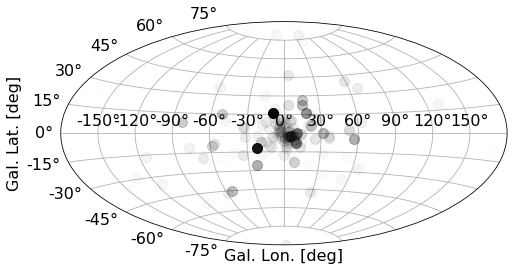

In [9]:
plt.subplot(projection='aitoff')
for i in range(len(gl)):
    plt.plot(np.deg2rad(gl[i]),np.deg2rad(gb[i]),'o',
             alpha=(np.max(dist)/dist[i])**2/np.max((np.max(dist)/dist)**2),color='black',markersize=10)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

<h3>And as a function of distance and longitude</h3>

Text(0, 0.5, 'Distance [kpc]')

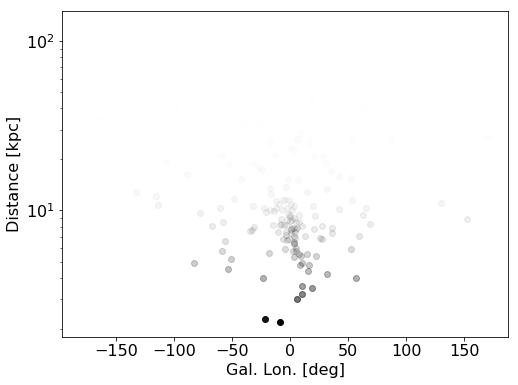

In [10]:
for i in range(len(gl)):
    plt.plot(gl[i],dist[i],'o',alpha=(np.max(dist)/dist[i])**2/np.max((np.max(dist)/dist)**2),color='black')
plt.yscale('log')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Distance [kpc]')

<h3>Histogram of distances</h3>

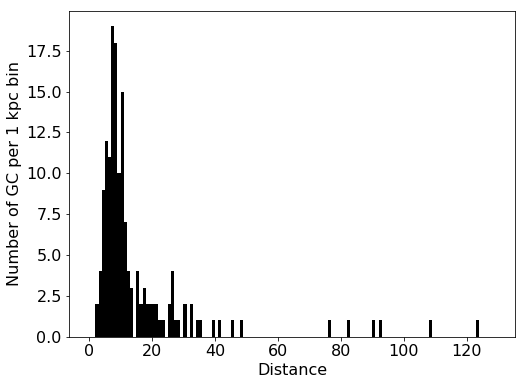

In [11]:
plt.hist(dist,bins=np.arange(130));
plt.xlabel('Distance')
plt.ylabel('Number of GC per 1 kpc bin');

<h3>Estimate masses from half-light radius (r_h) and velocity dispersion (sigma)<br>
    This is pure zero-order kinematics, and is probably flawed.</h3>

In [12]:
sigma = gc_vel['sig_v']
r_h = gc_vel['r_h']

In [13]:
# constants
G      = 6.67408e-11
Msol   = 1.98855e30
kpc2m  = 3.086e19
kms2ms = 1000
M_MW   = 2e10

In [14]:
# choose GCs which have all the information in all tables
good = np.where((sigma != -9999) & (r_h != -9999) & (dist != -9999))[0]
masses = np.full(len(gl),-9999)
masses[good] = 3/2 * (sigma[good]*kms2ms)**2*(dist[good]*np.tan(r_h[good]/60.)*kpc2m) / G / Msol

In [15]:
names = gc_general['ID']

In [16]:
names[np.argmax(masses)]

'NGC_5139'

<h3>NGC5139 is OmegaCen, so at least this works</h3>

<h3>Now as before but also weighted with masses</h3>

In [17]:
mass_dist_ratios = masses*(np.max(dist)/dist)**2 / np.max(masses*(np.max(dist)/dist)**2)

In [18]:
np.median(mass_dist_ratios[good])

0.013238064136918429

In [19]:
# to fill the unknown mass-to-light ratios, I use the median of the ones that I have to estimate a total contribution
mass_dist_ratios_fill = np.copy(mass_dist_ratios)
bad = np.where(mass_dist_ratios_fill < 0)[0]
mass_dist_ratios_fill[bad] = np.median(mass_dist_ratios[good])+np.abs(np.random.randn(len(bad))*np.median(mass_dist_ratios[good])*1)

Text(0, 0.5, '"Flux" contribution with increasing number of GCs')

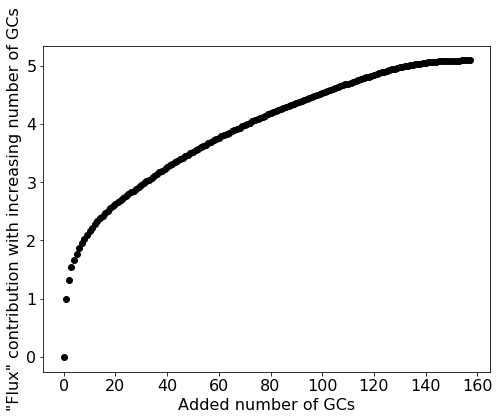

In [20]:
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(mass_dist_ratios_fill)))]),'o')
plt.xlabel('Added number of GCs')
plt.ylabel('"Flux" contribution with increasing number of GCs')

<h3>The jump from 0 to 1 indicates OmegaCen (as normalised to 1), adding all other GCs adds less (if weighted with mass/distance^2), but in total accounts to about 5 times of OmegaCen only. Good.</h3>

<h3>Now using the values from Baumgardt et al. (2018) because they provide most of the information we need</h3>

In [21]:
gc_baumgardt = pd.read_csv('MW_globclus_Baumgardt2018_combined_table_mod.txt',sep=',')

In [22]:
gc_baumgardt[0:3]

Cluster        RA       DEC  R_Sun   R_GC      Mass  Mass_err     V  V_err  \
0  NGC_104   6.02363 -72.08128   4.43   7.78  761000.0    5030.0  4.07   0.11   
1  NGC_288  13.18850 -26.58261   9.98  13.17  121000.0    3490.0  8.16   0.07   
2  NGC_362  15.80942 -70.84878   9.17  10.00  333000.0    4880.0  6.55   0.16   

   (M/L_V)  ...  rho_hm  sig_c  sig_hm  lgTrh    MF  F_REM  sig0  vesc  etac  \
0     1.72  ...    2.76   4.94    3.69   9.54 -0.47   0.52  12.2  49.7 -0.40   
1     2.40  ...    1.20   2.68    2.43   9.59 -0.44   0.68   3.3  11.1 -0.17   
2     1.67  ...    2.77   4.71    3.58   9.28 -0.88   0.49   8.8  31.7 -0.27   

   etah  
0 -0.04  
1 -0.09  
2 -0.09  

[3 rows x 26 columns]

<h3>To cross-validate indices and names, I calculate the galactic longitude and latitude from the given ra and dec values, and match them as needed ...</h3>

In [23]:
ra = gc_baumgardt['RA']
dec = gc_baumgardt['DEC']

Text(0, 0.5, 'DEC [deg]')

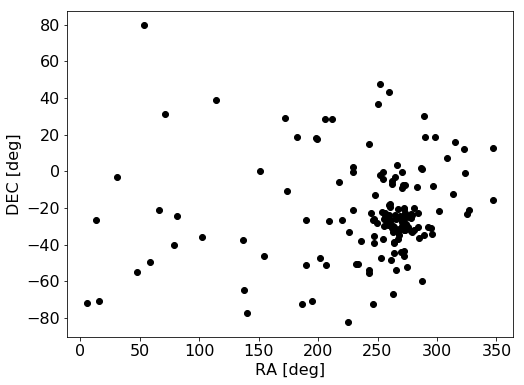

In [24]:
plt.plot(ra,dec,'o')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [25]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [26]:
i = 0
c_arr = []
for i in range(len(ra)):
    c = SkyCoord(ra=ra[i],
                 dec=dec[i], unit=(u.degree, u.degree))
    c_arr.append([c.galactic.l.deg,c.galactic.b.deg])
c_arr = np.array(c_arr)

In [27]:
c_arr.shape

(154, 2)

In [28]:
gl2 = c_arr[:,0]
gl2[gl2 > 180] -= 360
gb2 = c_arr[:,1]

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


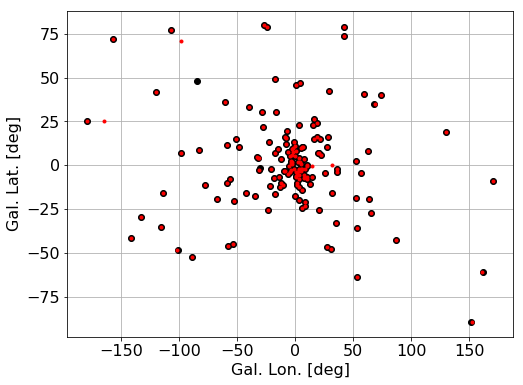

In [29]:
plt.plot(gl2,gb2,'o')
plt.plot(gl,gb,'r.')
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')

<h3>Most of the GCs are the same, a few (lt 5) are missing, and a few others (lt 5) are added, so not mch difference</h3)

In [30]:
names2 = gc_baumgardt['Cluster']

<h3>Now getting the masses from Baumgardt and doing the same excercise</h3>

In [31]:
masses2 = gc_baumgardt['Mass']
masses2_err = gc_baumgardt['Mass_err']

In [32]:
dist2 = gc_baumgardt['R_Sun']

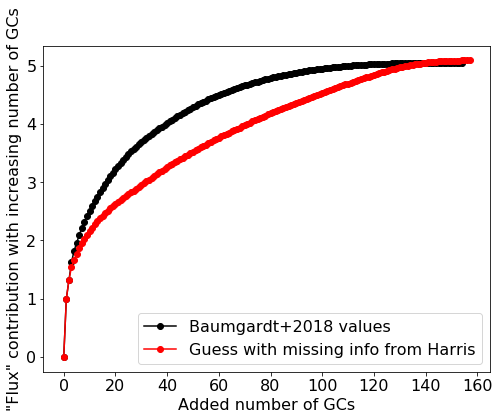

In [33]:
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(masses2*(np.max(dist2)/dist2)**2/np.max(masses2*(np.max(dist2)/dist2)**2))))]),'o-',label='Baumgardt+2018 values')
plt.plot(np.concatenate([np.array([0]),np.cumsum(np.flip(np.sort(mass_dist_ratios_fill)))]),'ro-',label='Guess with missing info from Harris')
plt.xlabel('Added number of GCs')
plt.ylabel('"Flux" contribution with increasing number of GCs')
plt.legend()

<h3>Basically the same absolute result (the path is not too important here, right now), good</h3>

<h3>Now what about mass to light ratios:</h3>

In [34]:
m2l2 = gc_baumgardt['(M/L_V)']
m2l2_err = gc_baumgardt['(M/L_V)_err']

Text(0, 0.5, 'Number of GCs per $0.1\\,\\mathrm{M_{\\odot}/L_{\\odot}}$ bin')

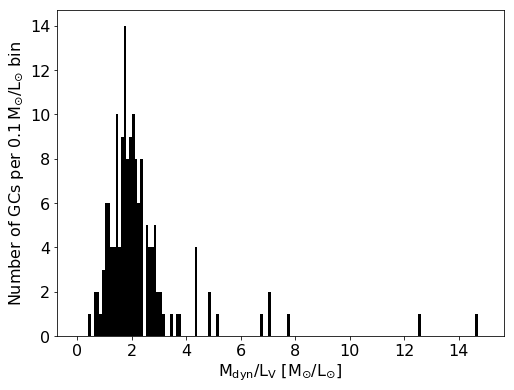

In [35]:
plt.hist(m2l2,bins=np.arange(0,15,0.1));
plt.xlabel(r'$\mathrm{M_{dyn}/L_V}$ [$\mathrm{M_{\odot}/L_{\odot}}$]')
plt.ylabel('Number of GCs per $0.1\,\mathrm{M_{\odot}/L_{\odot}}$ bin')

<h3>As described in the paper you showed me about NGC21..., most of the GCs show a M/L around 2, apparently compatibel with no dark matter. Somewhat smaller and larger values are probably also compatible with no dark matter. However, values above 5(?) or more seem to have some DM contributions, I guess.</h3>

<h3>From the assumption:<br>
    Mstar/L_V = 1<br>
    I calculate the stellar (and dark matter) mass for each GC as a zero-order estimate (this may change later).</h3>

In [36]:
Vmag = gc_baumgardt['V']

In [37]:
# absolute V-band magnitude of the Sun
Vsun = 4.83

In [38]:
Vmag_abs = Vmag - 5*np.log10(dist2*1e2)

<h3>The V-band luminosty of each GC is calculated as the total mass versus the mass-to-light ratio<h3>

In [39]:
L_V2 = masses2/m2l2

In [40]:
Mstar = masses2-(m2l2-1)*L_V2 # this means Mstar == L_V2, just in other units (as Mstar/L_V = 1)
Mstar_err = L_V2*np.sqrt((masses2_err/masses2)**2 + (m2l2_err/m2l2)**2)

<h3>Appearance as a function of stellar mass (OmegaCen the brightest again)</h3>

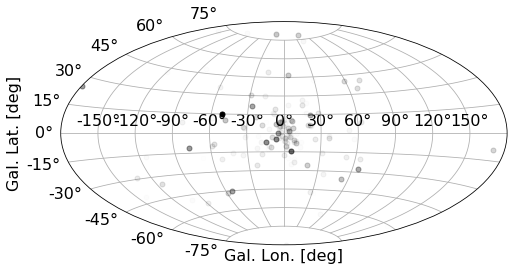

In [41]:
plt.subplot(projection='aitoff')
for i in range(len(gl2)):
    plt.plot(np.deg2rad(gl2[i]),np.deg2rad(gb2[i]),'o',
             alpha=(Mstar[i])**(1)/np.max((Mstar)**(1)),color='black',markersize=5)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid('True')
#plt.xlim(-20,20)
#plt.ylim(-20,20)

In [42]:
M_DM = masses2 - Mstar
M_DM[M_DM < 0] = 0

<h3>Now reading in your file with the GeV fluxes (I modified it to have comma separators)</h3>

In [43]:
gc_GeV = pd.read_csv('MWGCgamma_mod.txt',sep=',')

In [44]:
gc_GeV[0:3]

Name  distance[kpc]  log(Lgamma[erg/s])  errup  errdown         l  \
0     47Tuc            4.0               34.68   0.12     0.13  305.8953   
1  OmegaCen            4.8               34.44   0.13     0.15  309.1020   
2       M62            6.6               35.04   0.12     0.14  353.5746   

         b  IBISobs[ksec]  SPIobs[ksec]  3sigmaUL[ph/cm2/s]  
0 -44.8891         4995.8        3688.4             0.00000  
1  14.9683         4704.4        4018.6             0.00017  
2   7.3196        19675.1       19337.6             0.00000

In [45]:
names_GeV = gc_GeV['Name']
gl_GeV = gc_GeV['l']
gl_GeV[gl_GeV > 180] -= 360
gb_GeV = gc_GeV['b']

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<h3>I match the GCs in the two files (Baumgardt and yours) by the longitude and latitude values to get the indices of the GCs in the larger file</h3>

In [46]:
idx_GeV = []
for i in range(len(gl_GeV)):
    idx_GeV.append(np.where((np.round(gl2,1) == np.round(gl_GeV[i],1)) & 
                            (np.round(gb2,1) == np.round(gb_GeV[i],1)))[0])
idx_GeV = np.array(idx_GeV)
idx_GeV = idx_GeV.reshape(len(gl_GeV))

In [47]:
idx_GeV

array([  0,  27,  61,  85,  92,  93, 121, 125,  81,  45,  94, 120, 109,
       134,  38, 148,  88,  55,  49])

<h3>and for some reason I go back to absolute values, not logarithmic (though, I go back later)</h3>

In [48]:
lgL_GeV = gc_GeV['log(Lgamma[erg/s])']
lgL_GeV_errlo = gc_GeV['errdown']
lgL_GeV_errup = gc_GeV['errup']
L_GeV = 10**lgL_GeV

In [49]:
L_GeV_err = (10**(lgL_GeV+lgL_GeV_errup)-10**(lgL_GeV-lgL_GeV_errlo))/2

<h3>Reading off ther values from the Bartels paper</h3>

In [50]:
# from 1711.04778
Mstar_NB = 1.4e9
Mstar_NB_err = 0.6e9
Mstar_BB = 0.91e10
Mstar_BB_err = 0.7e10

Mstar_disk = 5e10
Mstar_disk_err = 0.5e10

Mstar_M31 = 5.5e10
Mstar_M31_err = 1.1e10

# reading off:
L_GeV_NB = 2e36
lgL_GeV_NB = np.log10(L_GeV_NB)
L_GeV_NB_err = 0.5e36

L_GeV_BB = 2e37
L_GeV_BB_err = 0.05*L_GeV_BB
lgL_GeV_BB = np.log10(L_GeV_BB)

L_GeV_disk_min = 0.5e37
L_GeV_disk_max = 15e37
L_GeV_disk = (L_GeV_disk_max+L_GeV_disk_min)/2
L_GeV_disk_err = (L_GeV_disk_max-L_GeV_disk_min)/2

L_GeV_M31 = 6.6e38
L_GeV_M31_err = 0.6/5.6*L_GeV_M31

<h3>This should be the value for M31, but I am not sure, if this is completely correct, but anyway can be changed easily</h3>

In [51]:
(5.6e-12*u.erg/u.s/u.cm**2*(785*u.kpc)**2).to(u.erg/u.s)*20 #?

<Quantity 6.57140792e+38 erg / s>

In [52]:
mm = np.logspace(3,12,1000)
Bartels2018 = 2e27*mm

<h3>Overview plot of the values that we have now, together with your linear function derived from the NB and BBM</h3>

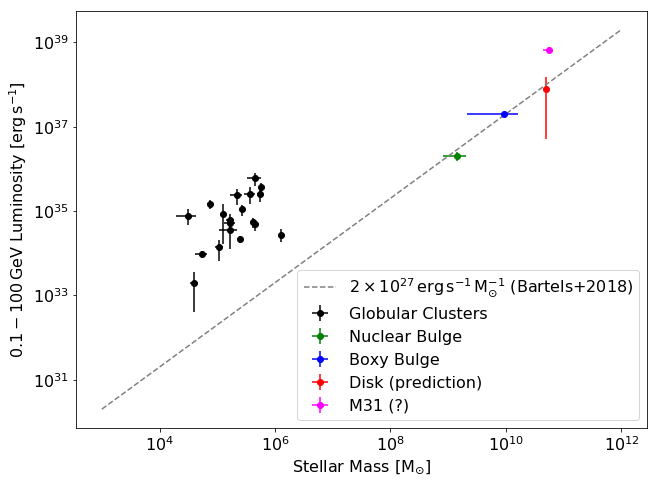

In [53]:
fig,ax = plt.subplots(figsize=(10.24,7.68))

ax.errorbar(Mstar[idx_GeV],L_GeV,xerr=Mstar_err[idx_GeV],yerr=L_GeV_err,fmt='o',label='Globular Clusters')
ax.errorbar(Mstar_NB,L_GeV_NB,xerr=Mstar_NB_err,yerr=L_GeV_NB_err,fmt='go',label='Nuclear Bulge')
ax.errorbar(Mstar_BB,L_GeV_BB,xerr=Mstar_BB_err,yerr=L_GeV_BB_err,fmt='bo',label='Boxy Bulge')
ax.errorbar(Mstar_disk,L_GeV_disk,xerr=Mstar_disk_err,yerr=L_GeV_disk_err,fmt='ro',label='Disk (prediction)')
ax.errorbar(Mstar_M31,L_GeV_M31,xerr=Mstar_M31_err,yerr=L_GeV_M31_err,color='magenta',fmt='o',label='M31 (?)')

ax.plot(mm,Bartels2018,color='gray',linestyle='--',
         label=r'$\mathrm{2 \times 10^{27}\,erg\,s^{-1}\,M_{\odot}^{-1}}$ (Bartels+2018)')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
ax.set_ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

ax.legend(loc=4)

<h3>Now, I make one array out of it and perform some fits with a power-law:<br>
    1) scipy.curve_fit (plain chi2)<br>
    2) emcee (with priors)<br>
    3) stan (with priors and uncertainties in both directions)<br>
    4) stan (everything together, accounting for the miss-match between data and model, determining a systematic uncertainty<h3>

In [54]:
masses_all = np.concatenate([Mstar[idx_GeV].values,np.array([Mstar_NB]),np.array([Mstar_BB])])
masses_all_err = np.concatenate([Mstar_err[idx_GeV].values,np.array([Mstar_NB_err]),np.array([Mstar_BB_err])])

L_GeV_all = np.concatenate([L_GeV.values,np.array([L_GeV_NB]),np.array([L_GeV_BB])])
L_GeV_all_err = np.concatenate([L_GeV_err.values,np.array([L_GeV_NB_err]),np.array([L_GeV_BB_err])])

In [55]:
print(names2[idx_GeV])
print(names_GeV)

0       NGC_104
27     NGC_5139
61     NGC_6266
85     NGC_6388
92        Ter_5
93     NGC_6440
121    NGC_6626
125    NGC_6652
81     Liller_1
45     NGC_6093
94     NGC_6441
120    NGC_6624
109    NGC_6541
134    NGC_6752
38     NGC_5904
148    NGC_7078
88     NGC_6397
55     NGC_6218
49     NGC_6139
Name: Cluster, dtype: object
0        47Tuc
1     OmegaCen
2          M62
3      NGC6388
4      Terzan5
5      NGC6440
6          M28
7      NGC6652
8      Liller1
9          M80
10     NGC6441
11     NGC6624
12     NGC6541
13     NGC6752
14     NGC5904
15         M15
16     NGC6397
17     NGC6218
18     NGC6139
Name: Name, dtype: object


<h3>Step 1) curve_fit</h3>

In [56]:
from scipy.optimize import curve_fit

In [57]:
def powerlaw_correlation(x,lgN,alpha):
    return 10**lgN*x**alpha

In [58]:
fit_p, fit_cov = curve_fit(powerlaw_correlation,masses_all,L_GeV_all,p0=[27,1],sigma=L_GeV_all_err)

In [59]:
fit_e = np.sqrt(np.diag(fit_cov))

<h3>Fitted parameters and uncertainties from curve_fit:</h3>

In [60]:
print('(lgNorm, alpha) = ',fit_p)
print('(lgNorm_err,alpha_err) = ',fit_e)

(lgNorm, alpha) =  [30.65479986  0.66048687]
(lgNorm_err,alpha_err) =  [0.31796751 0.03451236]


<h3>That is somewhat less steep than your correlation, and at another normalisation (as the GCs are somewhat higher and "to the left"</h3>

<h3>Step 2) emcee</h3>

In [61]:
import emcee

# Define the posterior
# Reminder: posterior(model parameters, data) = likelihood(data, model parameters) * prior(model parameters)
# emcee uses logarithmic probability distributions

# As prior, we assume normal distributions (may change later)
def lnprior(theta):
    lgN, alpha = theta
    mu_lgN = 30.6 # just the values from before
    sigma_lgN = 0.3
    mu_alpha = 0.66
    sigma_alpha = 0.03
    return -0.5*(lgN-mu_lgN)**2/sigma_lgN**2 -0.5*(alpha-mu_alpha)**2/sigma_alpha**2

# As likelihood, we assume the normal distribution (gaussian uncertainties on extracted parameters)
def lnlike(theta, x, y, yerr):
    lgN, alpha = theta
    model = powerlaw_correlation(x,lgN,alpha)
    return -0.5*(np.sum( ((y-model)/yerr)**2 ))

# full posterior
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [62]:
import scipy.optimize as op

In [63]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, (30.6, 0.3), args=(masses_all, L_GeV_all, L_GeV_all_err),)
N_ml, alpha_ml = result.x

<h3>Again, using the maximum likelihood solution as initial guess for the emcee sampler</h3>

In [64]:
result

      fun: 72.48405260400959
 hess_inv: array([[ 0.01583411, -0.0017011 ],
       [-0.0017011 ,  0.00018757]])
      jac: array([9.53674316e-07, 2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 68
      nit: 7
     njev: 17
   status: 0
  success: True
        x: array([30.65481882,  0.66048478])

In [65]:
ndim, nwalkers = 2, 10
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(masses_all, L_GeV_all, L_GeV_all_err))

In [66]:
from tqdm import tqdm_notebook as tqdm

In [67]:
_ = sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:01<00:00, 1699.80it/s]


In [68]:
samples = sampler.flatchain
samples.shape

(20000, 2)

In [69]:
import corner

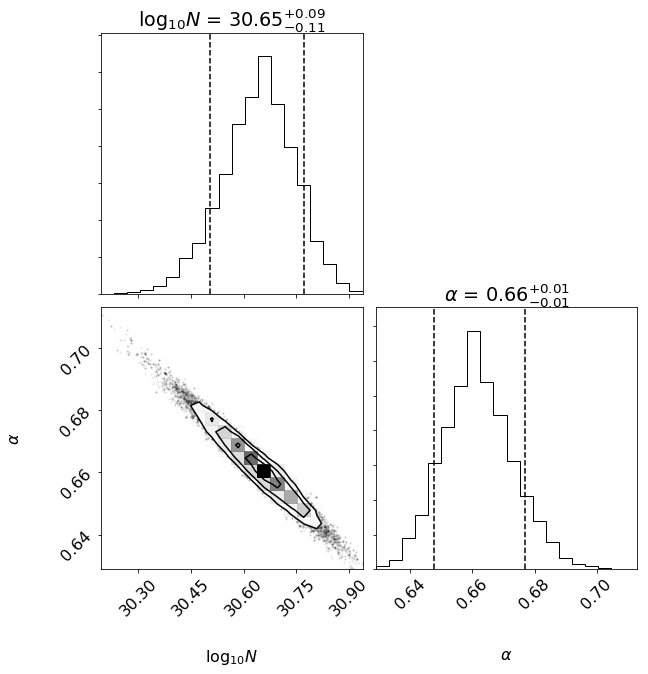

In [70]:
#let's plot the results
fig = corner.corner(samples, labels=[r'$\log_{10}N$',r'$\alpha$'],
                    #range=((0.5e35,1.5e35),(0.7,0.8)),
                    quantiles=[0.1,0.9],show_titles=True)
fig.set_size_inches(10,10)

<h3>Parameters look good, let's see how the model performs (probably bad because the model is not capturing all the points)</h3>

In [71]:
# evaluate models according to posterior sampling
N_model = len(mm)

y_models = np.zeros((N_model,samples.shape[0]))
for i in range(samples.shape[0]):
    y_models[:,i] = powerlaw_correlation(mm,samples[i,0],samples[i,1])

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

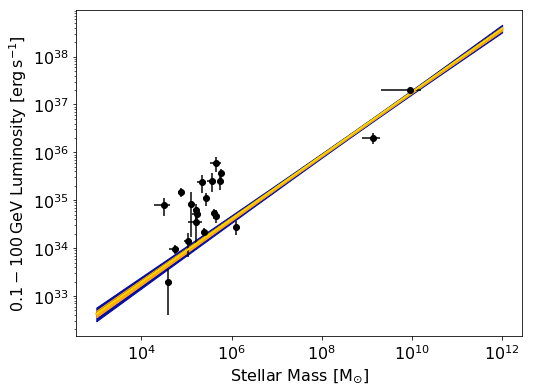

In [72]:
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko',label='measured values')
plt.plot(mm,powerlaw_correlation(mm,*fit_p))

level = 95.4
plt.fill_between(mm,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Model (95th)')

level = 68.3
plt.fill_between(mm,
                np.percentile(y_models, 50 - 0.5*level, axis=1 ),
                np.percentile(y_models, 50 + 0.5*level, axis=1 ),
                color='xkcd:yellowish orange',alpha=1,label='Model (68th)')

fit_model = np.median(y_models,axis=1)
plt.plot(mm,fit_model,linewidth=2,color='gold',label='Median model')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

<h3>Basically same result (as expected), and we see that many points are just "above" the line, which we will take into account in step 4), now step 3), stan:</h3>

In [73]:
import stan_utility
import pystan
import pickle

<h3>First, let's generate some data that should follow a powerlaw model that we put into, however with error bars in both directions<h3>

In [74]:
model_pl_gen = stan_utility.compile_model('generate_powerlaw_xy.stan')

Using cached StanModel


<h3>Here we define our fake data set to be sure that the other things (real data) will work in the end:</h3>

In [75]:
N = 20 # number of observations to predict
lgNorm = 30.6 # as before
alpha = 0.7 # as before
sigma_x_percent = 0.1 + np.random.rand(N)*0.3 # the uncertainty of the masses in percentl, drawn from a uniform distribution between 10 and 40 %
sigma_y_percent = 0.05 + np.random.rand(N)*0.15 # same for the fluxes, but between 5 and 20%
lgx_min = 3 # minimum value to be draw for the masses 10^3
lgx_max = 10 # maximum 10^10

data_gen = dict(N = N,
                lgNorm = lgNorm,
                alpha = alpha,
                sigma_x_percent = sigma_x_percent,
                sigma_y_percent = sigma_y_percent,
                lgx_min = lgx_min,
                lgx_max = lgx_max)

gen = model_pl_gen.sampling(data=data_gen,seed=123456, algorithm='Fixed_param', iter=1, chains=1)

In [76]:
x_obs = gen['x_obs'].reshape(N)
x_latent = gen['x_latent'].reshape(N)
y_obs = gen['y_obs'].reshape(N)
y_latent = gen['y_latent'].reshape(N)

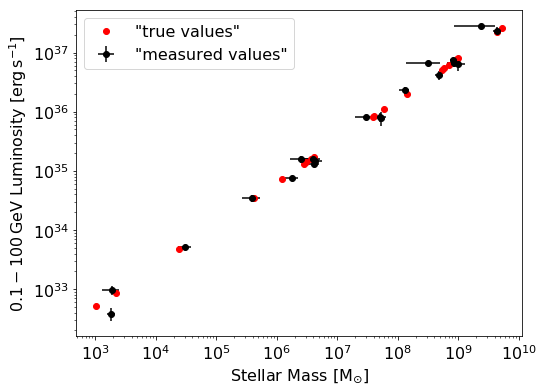

In [77]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')
plt.loglog(x_latent,y_latent,'ro',label='"true values"')
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()

<h3>The red values are draw from the generative model, and the obscured to appear "as measured" (black points with "error bars")</h3>

<h3>In general, this would be much more scattered and a cloud of points somewhere (the GCs), this will be included later</h3>

In [78]:
# where to evaluate the model for posterior prediction
N_model = 200
x_model = np.logspace(2,12,N_model)

In [79]:
# dictionary for test data set and prior
data_test = dict(N = N,
            x_obs = x_obs,
            y_obs = y_obs,
            sigma_x = sigma_x_percent*x_latent,
            sigma_y = sigma_y_percent*y_latent,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 30,
            sigma_lgNorm = 1,
            mu_alpha = 1,
            sigma_alpha = 0.3)

In [80]:
"""## compile model (if not yet compiled):
model_pl = pystan.StanModel('fit_powerlaw_xy.stan')

## save it to the file 'filename.pkl' for later use
with open('fit_powerlaw_xy.pkl', 'wb') as f:
    pickle.dump(model_pl, f)"""
    
#read filename.pkl (if already compiled)
model_pl = pickle.load(open('fit_powerlaw_xy.pkl', 'rb'))

In [81]:
init = {}
init['lgNorm'] = 30.
init['alpha'] = 1.
init['lgx_latent'] = np.log10(x_obs)
op = model_pl.optimizing(data=data_test,as_vector=False,init=init)

In [82]:
print('(lgNorm, alpha) = ',op['par']['lgNorm'],op['par']['alpha'])

(lgNorm, alpha) =  30.420831517490868 0.7214274367395704


<h3>Now full sampling to get the distributions of lgNorm and alpha:</h3>

In [83]:
yfit = op['par']['powerlaw']

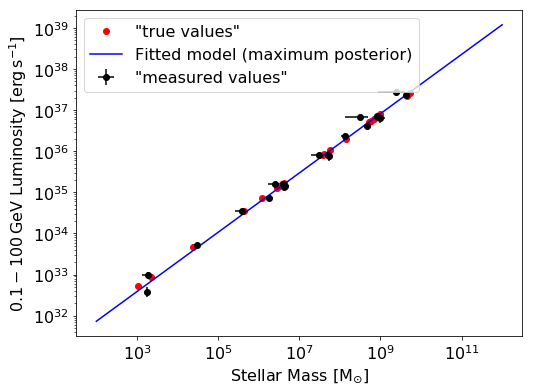

In [84]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')
plt.loglog(x_latent,y_latent,'ro',label='"true values"')
plt.loglog(x_model,yfit,label='Fitted model (maximum posterior)',color='blue')
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()


In [85]:

# fit the model
fit_pl_test = model_pl.sampling(data=data_test,verbose=True,chains=4,iter=2000,algorithm='HMC')

In [86]:
print(fit_pl_test.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  30.33  9.8e-3   0.09  30.15  30.27  30.33  30.39  30.51     86   1.05
alpha    0.74  1.5e-3   0.01   0.71   0.73   0.73   0.74   0.76     66   1.06

Samples were drawn using HMC at Tue Nov 12 11:50:46 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h3>Let's check how this looks like, again</h3>

In [87]:
chain = fit_pl_test.extract()

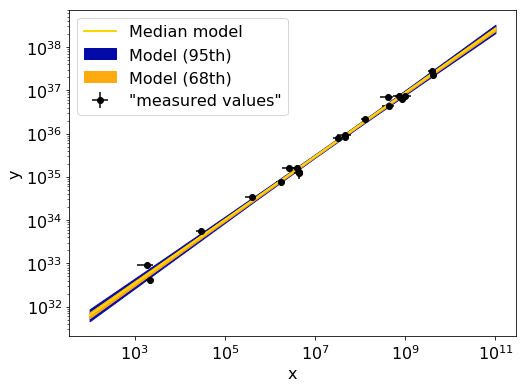

In [88]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x_percent*x_latent,
             yerr=sigma_y_percent*y_latent,fmt='ko',label='"measured values"')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='Model (68th)')

fit_model = np.median(chain['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='Median model')
    
plt.xlabel('x')
plt.ylabel('y')

plt.xscale('log')
plt.yscale('log')

plt.legend()

#plt.plot(x_model,10**lgNorm*(x_model/1e7)**alpha,color='cyan',linewidth=4)

<h3>In particular, this model fits for the "correct position" of the the data points, i.e. where the true values would be, according to the model, and according to the uncertainties in x and y (not yet accounting for "systematic effects"):</h3>

In [89]:
colors = plt.cm.jet(y_obs/np.mean(y_obs))

Text(0, 0.5, 'y')

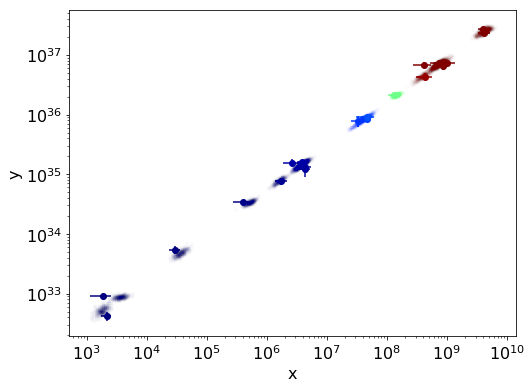

In [90]:
for i in range(N):
    plt.loglog(10**chain['lgx_latent'][::10,i],10**chain['lgy_true'][::10,i],'.',alpha=0.01,color=colors[i])
    plt.errorbar(x_obs[i],y_obs[i],yerr=sigma_y_percent[i]*y_latent[i],xerr=sigma_x_percent[i]*x_latent[i],fmt='o',color=colors[i])
plt.xlabel('x')
plt.ylabel('y')

<h3>Each point of clouds is basically the posterior prediction of the data points. As is in this case, the measured points and the predicted posteriors coincide. In the data case (see below), this is not true any more and we will need a parameter (or two) to describe the "systematics".</h3>

<h3>Now a run for the real data</h3>

In [85]:
# where to evaluate the model for posterior prediction
N_model = 100
x_model = np.logspace(2,11,N_model)

In [86]:
N_obs = len(masses_all)

# dictionary for data set and prior
data = dict(N = N_obs,
            x_obs = masses_all,
            y_obs = L_GeV_all,
            sigma_x = masses_all_err,
            sigma_y = L_GeV_all_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 30,
            sigma_lgNorm = 1,
            mu_alpha = 0.7,
            sigma_alpha = 0.1)

In [87]:
# fit the model
fit_pl = model_pl.sampling(data=data,verbose=True,chains=4,iter=2000,algorithm='HMC')

In [88]:
print(fit_pl.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  36.61    1.89   2.67  31.78  34.73  38.05  38.23  38.56      2  14.27
alpha    -0.3    0.34   0.48  -0.65  -0.59  -0.56   0.04   0.56      2  13.75

Samples were drawn using HMC at Wed Nov 13 17:36:58 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [89]:
chain = fit_pl.extract()

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

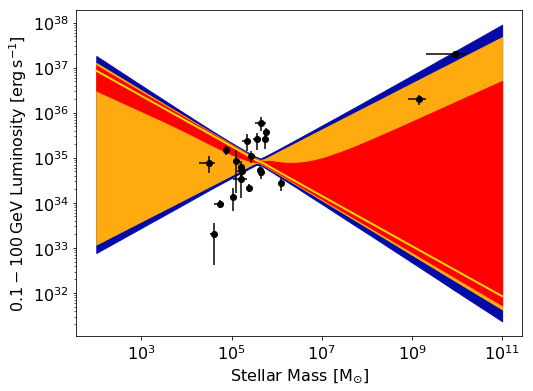

In [90]:
# make some plots of interest

#plt.loglog(x_obs,y_obs,'ko')
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0)

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1)

level = 50
plt.fill_between(x_model,
                np.percentile(chain['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='red',alpha=1)

fit_model = np.median(chain['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

#plt.plot(x_model,10**lgNorm*(x_model/1e7)**alpha,color='cyan',linewidth=4)

<h3>Clearly, the model is ... bad, and we need to include a parameter which describes this, typically introduced as "systematic uncertainty", which however, is quantifiable given the values we have. We will cahnge the model and also fit for this parameterm, either as varying the same way in x and y, or independently. The latter might be more reasonable since the flux measurements are in general less affected by modelling.</h3>

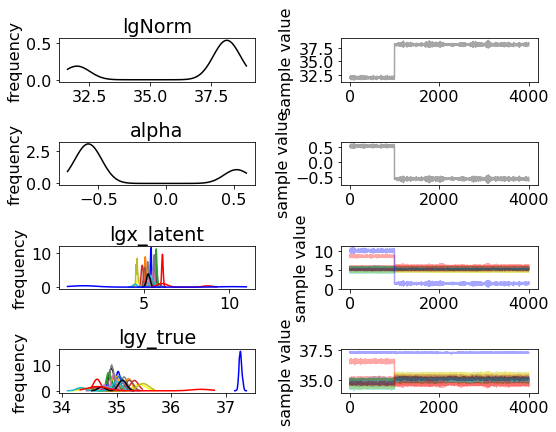

In [91]:
fig = fit_pl.plot(['lgNorm','alpha','lgx_latent','lgy_true'])
fig.tight_layout()

<h3>The normalisation and the powerlaw index are bimodal, i.e. the correlation only wekaly determined by the two points. Let's check the posterior prediction for each GC in the sample, as well as the NB and BB, individually</h3>

In [92]:
import matplotlib.colors as colors

In [100]:
colors_all = colors.PowerNorm(1,vmin=np.min(np.log10(L_GeV_all)),vmax=np.max(np.log10(L_GeV_all)))

In [94]:
names_all = np.concatenate([names_GeV.values,np.array(['NB']),np.array(['BB'])])

In [95]:
names_all

array(['47Tuc', 'OmegaCen', 'M62', 'NGC6388', 'Terzan5', 'NGC6440', 'M28',
       'NGC6652', 'Liller1', 'M80', 'NGC6441', 'NGC6624', 'NGC6541',
       'NGC6752', 'NGC5904', 'M15', 'NGC6397', 'NGC6218', 'NGC6139', 'NB',
       'BB'], dtype=object)

In [105]:
mass_scl = 10**np.round(np.log10(masses_all))
Lumi_scl = 10**np.round(np.log10(L_GeV_all))

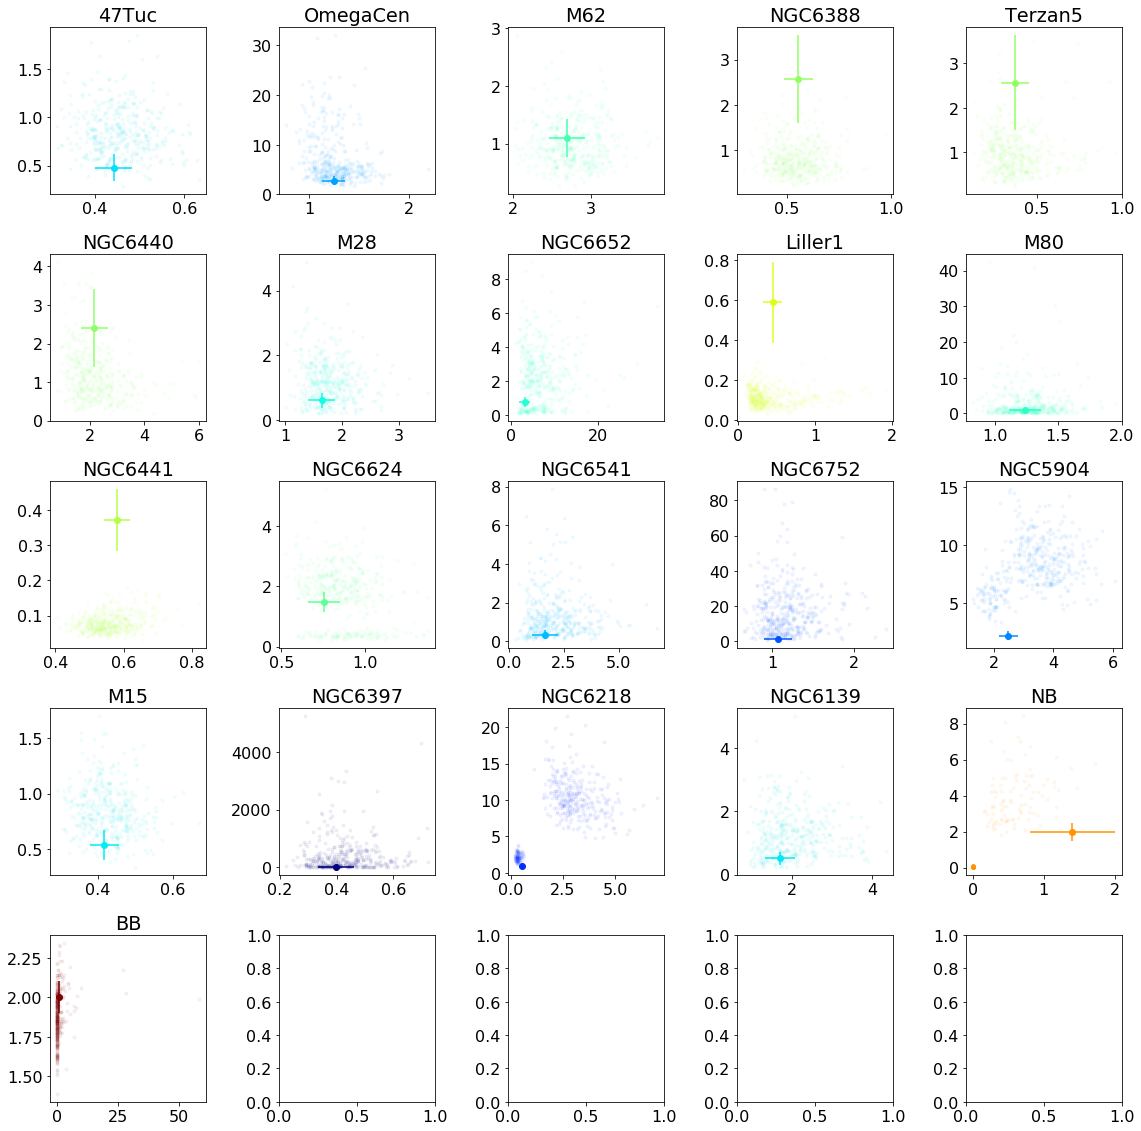

In [107]:
fig,axes = plt.subplots(5,5,figsize=(16,16))

cnt = 0
for i in range(5):
    for j in range(5):
        if (cnt < len(masses_all)):
            axes[i,j].plot(chain['ppc_x'][::10,cnt]/mass_scl[cnt],
                           chain['ppc_y'][::10,cnt]/Lumi_scl[cnt],
                           '.',alpha=0.05,color=plt.cm.jet(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].errorbar(masses_all[cnt]/mass_scl[cnt],
                               L_GeV_all[cnt]/Lumi_scl[cnt],
                               xerr=masses_all_err[cnt]/mass_scl[cnt],
                               yerr=L_GeV_all_err[cnt]/Lumi_scl[cnt],fmt='o',
                               color=plt.cm.jet(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].set_title(names_all[cnt])
            #axes[i,j].set_yscale('log')
            #axes[i,j].set_xscale('log')
            cnt += 1
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

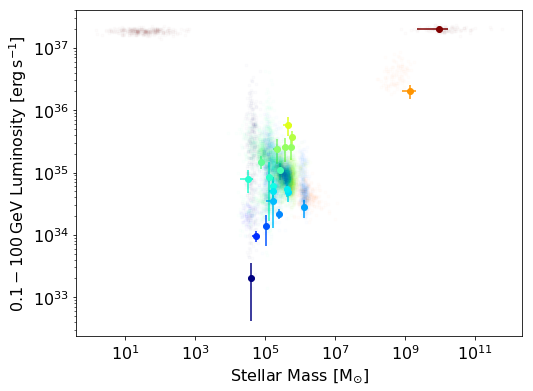

In [108]:
for i in range(len(masses_all)):
    #plt.loglog(10**chain['lgx_latent'][::10,i],10**chain['lgy_true'][::10,i],'.',alpha=0.01,color=colors[i])
    plt.loglog(chain['ppc_x'][::10,i],chain['ppc_y'][::10,i],'.',alpha=0.01,color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
    plt.errorbar(masses_all[i],L_GeV_all[i],xerr=masses_all_err[i],yerr=L_GeV_all_err[i],fmt='o',color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')


<h3>Ther model as is now cannot match the data points in all cases, even the bimodal things sometimes fail to match the data. Let's include "systematics" in different ways:</h3>

<h3>Step 4) a full model</h3>

In [109]:
"""## compile model (if not yet compiled):
model_pl_sys = pystan.StanModel('fit_powerlaw_xy_sigmaxy.stan')

## save it to the file 'filename.pkl' for later use
with open('fit_powerlaw_xysigmaxy.pkl', 'wb') as f:
    pickle.dump(model_pl_sys, f)"""
    
#read filename.pkl (if already compiled)
model_pl_sys = pickle.load(open('fit_powerlaw_xysigmaxy.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_156991189cd8939a80ec44cc8e8413fb NOW.


<h3>In this model we allow for a common systematics scale parameter that is multiplied to the uncertainties in x and y, equivalently for all data points that we want to fit. Here, we then also include the distances to the objects to have a prediction for the flux of the 511 keV line, not only the luminosity</h3>

In [111]:
dist_all = np.concatenate([dist2[idx_GeV].values,np.array([8.2]),np.array([8.2])])

In [113]:
N_obs = len(masses_all)

# dictionary for data set and prior
data = dict(N = N_obs,
            x_obs = masses_all,
            y_obs = L_GeV_all,
            sigma_x = masses_all_err,
            sigma_y = L_GeV_all_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 30,
            sigma_lgNorm = 1,
            mu_alpha = 0.7,
            sigma_alpha = 0.1,
            dist_obs = dist_all)

In [114]:
# fit the model
fit_pl_sys = model_pl_sys.sampling(data=data,verbose=True,chains=4,iter=10000,algorithm='HMC')

In [116]:
print(fit_pl_sys.stansummary(['lgNorm','alpha','sigma','GC511_flux_total']))

Inference for Stan model: anon_model_156991189cd8939a80ec44cc8e8413fb.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm            31.29    0.01   0.45  30.38  30.99   31.3   31.6  32.13   1886    1.0
alpha              0.65  1.9e-3   0.08    0.5   0.59   0.65    0.7   0.81   1728    1.0
sigma              3.64    0.02   0.62   2.65    3.2   3.56    4.0   5.06   1012    1.0
GC511_flux_total    1.8    1.63 231.18 9.6e-4 1.4e-3 1.8e-3 2.8e-3   0.06  20008    1.0

Samples were drawn using HMC at Wed Nov 13 17:44:53 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


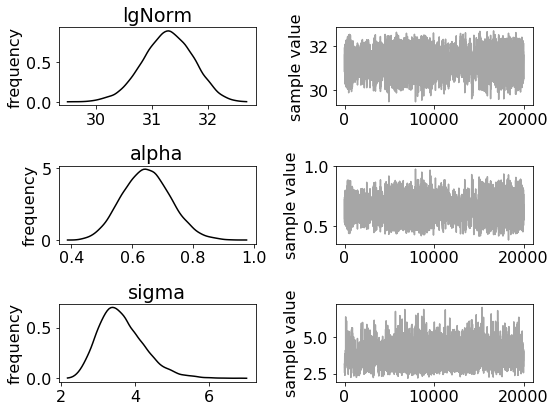

In [117]:
fig = fit_pl_sys.plot(['lgNorm','alpha','sigma'])
fig.tight_layout()

<h3>This general systematics parameter is determined to be around 3 (in log-space), i.e. it increases the uncertainty in "dex" by around 3 (in both, x and y)</h3>

In [118]:
chain_sys = fit_pl_sys.extract()

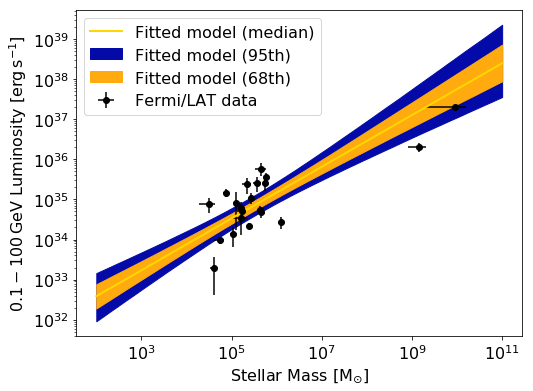

In [410]:
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko',label='Fermi/LAT data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain_sys['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sys['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Fitted model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain_sys['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sys['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='Fitted model (68th)')

fit_model = np.median(chain_sys['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='Fitted model (median)')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()

<h3>And again predictions</h3>

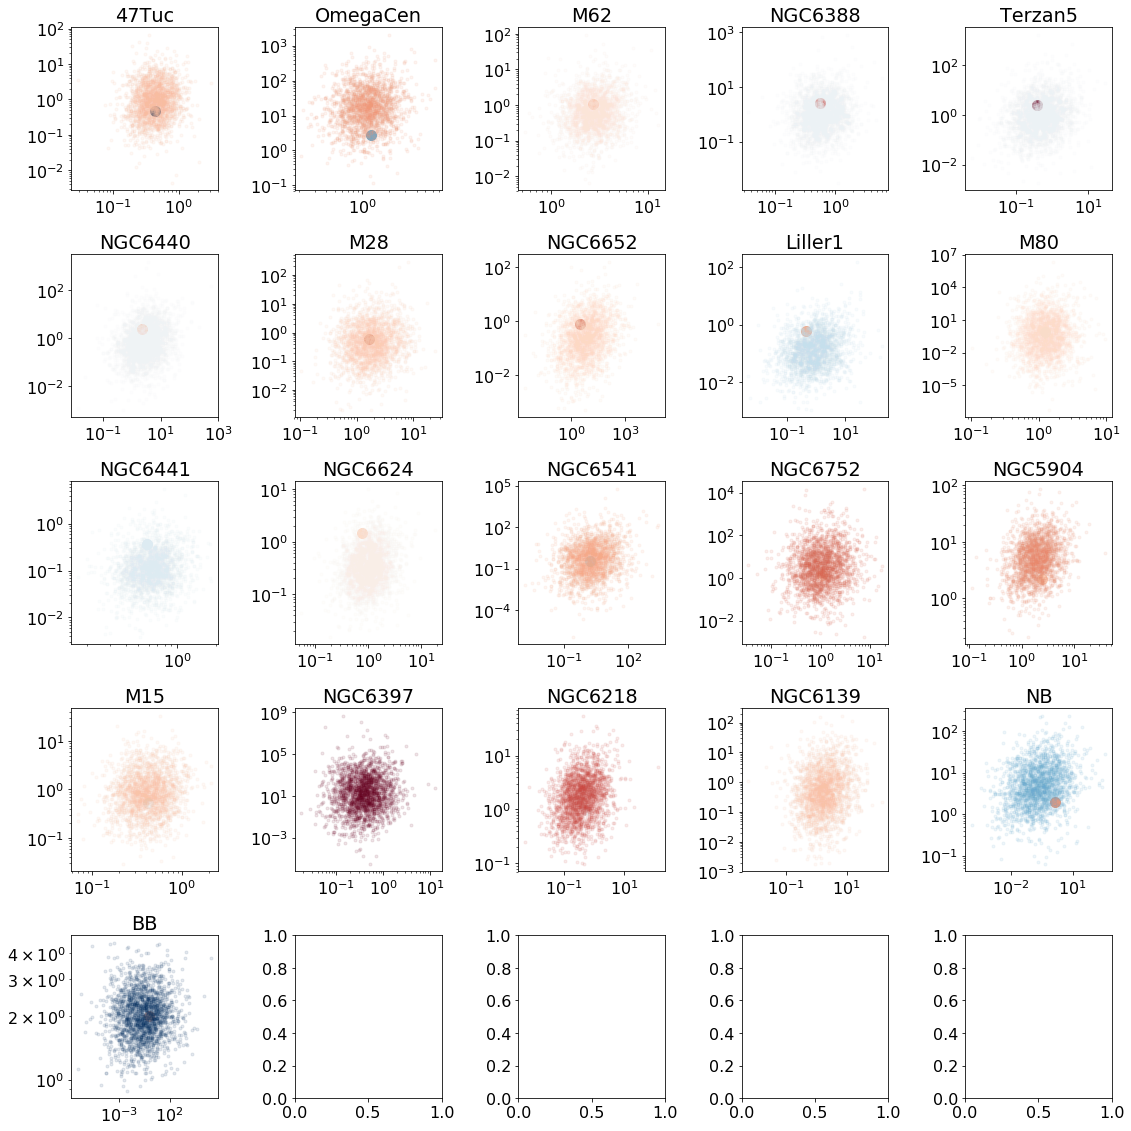

In [120]:
fig,axes = plt.subplots(5,5,figsize=(16,16))

cnt = 0
for i in range(5):
    for j in range(5):
        if (cnt < len(masses_all)):
            axes[i,j].plot(chain_sys['ppc_x'][::10,cnt]/mass_scl[cnt],
                           chain_sys['ppc_y'][::10,cnt]/Lumi_scl[cnt],'.',alpha=0.1,
                           color=plt.cm.RdBu(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].errorbar(masses_all[cnt]/mass_scl[cnt],
                               L_GeV_all[cnt]/Lumi_scl[cnt],
                               xerr=masses_all_err[cnt]/mass_scl[cnt],
                               yerr=L_GeV_all_err[cnt]/Lumi_scl[cnt],fmt='o',markersize=10,zorder=-10000,
                               color=plt.cm.RdBu(colors_all(np.log10(L_GeV_all[len(masses_all)-cnt-1]))))
            axes[i,j].set_title(names_all[cnt])
            axes[i,j].set_yscale('log')
            axes[i,j].set_xscale('log')
            cnt += 1
plt.tight_layout()

(1e+29, 1e+39)

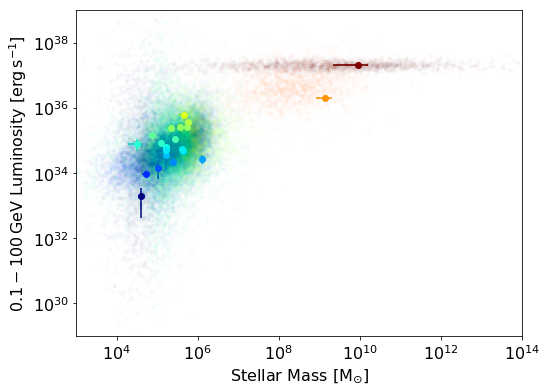

In [121]:
for i in range(len(masses_all)):
    #plt.loglog(10**chain_sys['lgx_latent'][::10,i],10**chain_sys['lgy_true'][::10,i],'.',alpha=0.01,color=colors[i])
    plt.loglog(chain_sys['ppc_x'][::10,i],chain_sys['ppc_y'][::10,i],'.',alpha=0.01,color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
    plt.errorbar(masses_all[i],L_GeV_all[i],xerr=masses_all_err[i],yerr=L_GeV_all_err[i],fmt='o',color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.xlim(1e3,1e14)
plt.ylim(1e29,1e39)
#chain_sys['ppc_x']

<h3>Now the degeneracy is gone, however by increasing the true uncertainties, considering stellar mass (assumed to be equivalent to the mass-luminosity-ratio of 1) and the GeV luminosity (integrating over a specific region, maybe considering different size); especially the diffuse emission parts (NB and BB) might have different systematics than the population of GCs</h3>

<h3>Example prediction of 47 Tuc in 511 keV flux:</h3>

Text(0.5, 1.0, 'NGC_104, $(   1.4 ^{+  2.9} _{ -0.9} ) \\times 10^{-5}\\,\\mathrm{ph\\,cm^{-2}\\,s^{-1}}$')

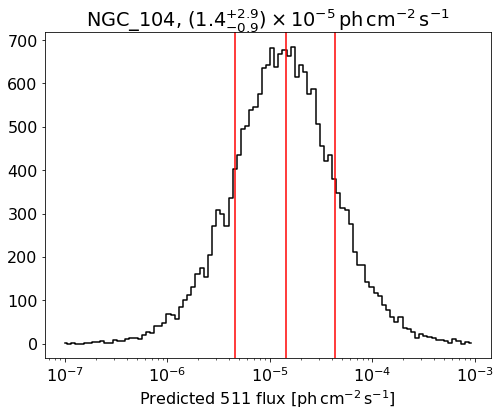

In [449]:
prediction_47Tuc = np.histogram(chain_sys['five11_flux'][:,0].ravel(),bins=np.logspace(-7,-3,100));
plt.step(prediction_47Tuc[1][0:-1],prediction_47Tuc[0],where='mid')
plt.xscale('log')
plt.xlabel(r'Predicted 511 flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
median_flux_47Tuc = np.round(np.percentile(chain_sys['five11_flux'][:,0],50),7)
perc68hi_flux_47Tuc = np.round(np.percentile(chain_sys['five11_flux'][:,0],50+68.3/2),7)
perc68lo_flux_47Tuc = np.round(np.percentile(chain_sys['five11_flux'][:,0],50-68.3/2),7)
errlo_flux_47Tuc = perc68lo_flux_47Tuc - median_flux_47Tuc
errhi_flux_47Tuc = perc68hi_flux_47Tuc - median_flux_47Tuc
plt.axvline(median_flux_47Tuc,color='red')
plt.axvline(perc68hi_flux_47Tuc,color='red')
plt.axvline(perc68lo_flux_47Tuc,color='red')
plt.title(names2[0]+', '+str(r'$( %5.3s ^{+%5.3s} _{%5.4s} ) \times 10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$' % (median_flux_47Tuc*1e5,errhi_flux_47Tuc*1e5,errlo_flux_47Tuc*1e5)))

<h3>And for all the sources</h3>

In [123]:
nbins = 200

In [124]:
five11_flux_edges = np.logspace(-9,-1,nbins+1)

In [125]:
five511_flux_bins = (five11_flux_edges[0:-1]+five11_flux_edges[1:])/2

In [126]:
gc511_pdfs = np.zeros((len(masses_all),nbins))
for i in range(len(masses_all)):
    gc511_pdfs[i,:] = (np.histogram(chain_sys['five11_flux'][:,i].ravel(),bins=np.logspace(-9,-1,nbins+1)))[0]

Text(0, 0.5, 'Posterior PDF [a.u.]')

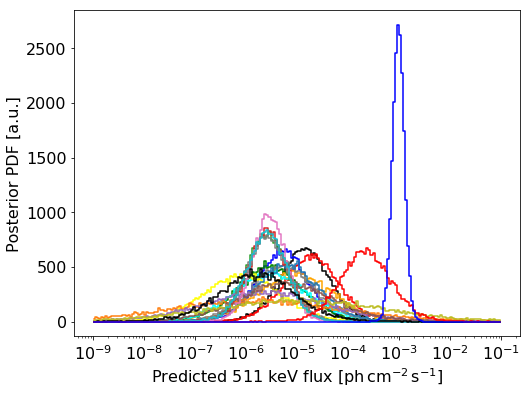

In [128]:
for i in range(len(masses_all)):
    plt.step(five511_flux_bins,gc511_pdfs[i,:],where='mid')
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
#plt.yscale('log')

<h3>Prediction for the BB component:</h3>

In [133]:
from bayescorner import bayescorner

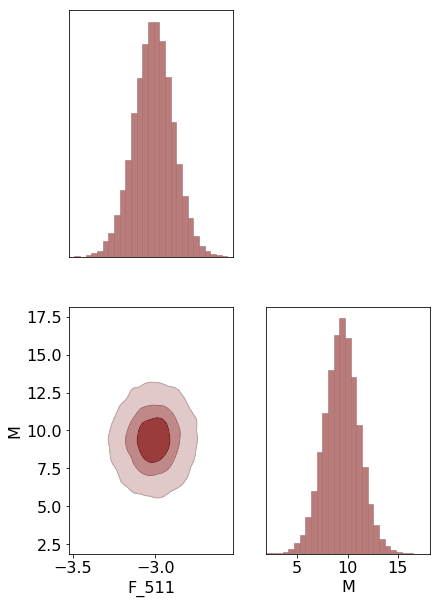

In [134]:
fig = bayescorner(params=[np.log10(chain_sys['ppc_x'][:,-1].ravel()),
                          np.log10(chain_sys['five11_flux'][:,-1].ravel())],
                  param_names=['M','F_511'])

<h3>As said before, maybe the diffuse and point-like sources have different systematic uncertainties, i.e. we declare families for diffuse and point-like, and do the fit again. This now includes two systematics parameters, one for each family:</h3>

In [153]:
"""## compile model (if not yet compiled):
model_pl_sysxy_fam = pystan.StanModel('fit_powerlaw_xy_sigmaxy_families.stan')

## save it to the file 'filename.pkl' for later use
with open('fit_powerlaw_xy_sigmaxy_fam.pkl', 'wb') as f:
    pickle.dump(model_pl_sysxy_fam, f)"""
    
#read filename.pkl (if already compiled)
model_pl_sysxy_fam = pickle.load(open('fit_powerlaw_xy_sigmaxy_fam.pkl', 'rb'))

In [138]:
family_idx = np.concatenate([np.ones(19),np.zeros(2)])

In [154]:
dist_all = np.concatenate([dist2[idx_GeV].values,np.array([8.2]),np.array([8.2])])


In [155]:
N_obs = len(masses_all)

# dictionary for data set and prior
data_sysxy_fam = dict(N = N_obs,
            x_obs = masses_all,
            y_obs = L_GeV_all,
            dist_obs = dist_all,
            sigma_x = masses_all_err,
            sigma_y = L_GeV_all_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 31.5,
            sigma_lgNorm = 1.0,
            mu_alpha = 0.7,
            sigma_alpha = 0.2,
            sys_xy_width_diffuse = 1.0,
            sys_xy_width_GC = 1.0,
            family_idx = family_idx,
            NGC = len(Mstar.values),
            GC_masses = Mstar.values,
            GC_masses_err = Mstar_err.values,
            GC_dist = dist2.values)

In [156]:
# fit the model
fit_pl_sysxy_fam = model_pl_sysxy_fam.sampling(data=data_sysxy_fam,verbose=True,chains=4,iter=10000,algorithm='HMC')

In [158]:
print(fit_pl_sysxy_fam.stansummary(['lgNorm','alpha','GC511_flux_total_sample','GC511_flux_total_GC','sys_xy_diffuse','sys_xy_GC']))

Inference for Stan model: anon_model_3a5363a9a2c3f5560ab382296a02a4fe.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm                    32.0  2.9e-3   0.44  31.01  31.75  32.04   32.3  32.74  22974    1.0
alpha                     0.52  5.1e-4   0.08    0.4   0.47   0.51   0.56    0.7  22096    1.0
GC511_flux_total_sample   0.28     0.2  28.62 8.6e-5 1.8e-4 3.2e-4 8.4e-4   0.04  19795    1.0
GC511_flux_total_GC     1.3e-3  2.5e-4   0.03 2.4e-4 3.6e-4 4.5e-4 5.8e-4 2.2e-3  20024    1.0
sys_xy_diffuse             2.7    0.02   1.91    1.1   1.63   2.18    3.1   7.56   6245    1.0
sys_xy_GC                 3.46  7.6e-3    0.6   2.54   3.04   3.38   3.79   4.86   6134    1.0

Samples were drawn using HMC at Wed Nov 13 17:50:38 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is th

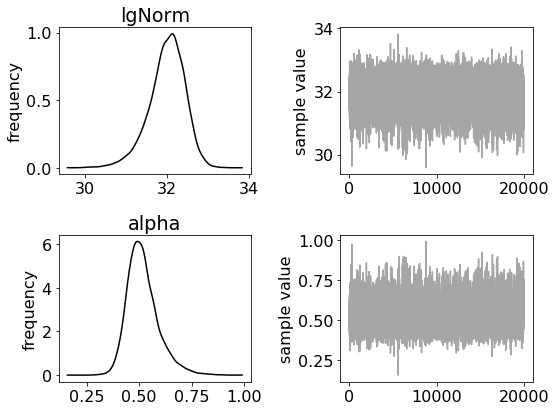

In [160]:
fig = fit_pl_sysxy_fam.plot(['lgNorm','alpha'])
plt.tight_layout()

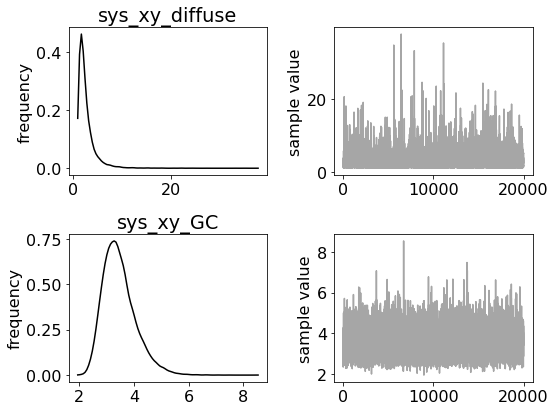

In [161]:
fig = fit_pl_sysxy_fam.plot(['sys_xy_diffuse','sys_xy_GC'])
plt.tight_layout()

<h3>The fit parameters do not change very much, as expected, however the systematics parameters are different for diffuse and globular clusters. The diffuse one is only around 2.2, but with a very lange tail to high values; the GC one is again around 3.4, and not too broad</h3>

In [162]:
chain_sysxy_fam = fit_pl_sysxy_fam.extract()

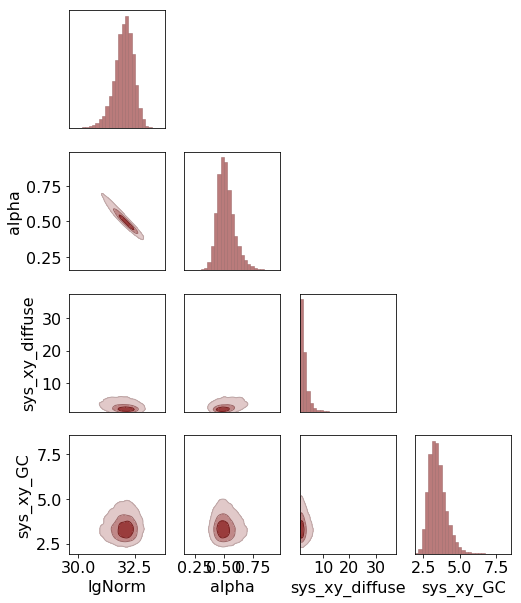

In [165]:
fig = bayescorner(params=[chain_sysxy_fam['alpha'],
                          chain_sysxy_fam['sys_xy_diffuse'],
                          chain_sysxy_fam['sys_xy_GC'],
                          chain_sysxy_fam['lgNorm']],
                 param_names=['alpha','sys_xy_diffuse','sys_xy_GC','lgNorm'])

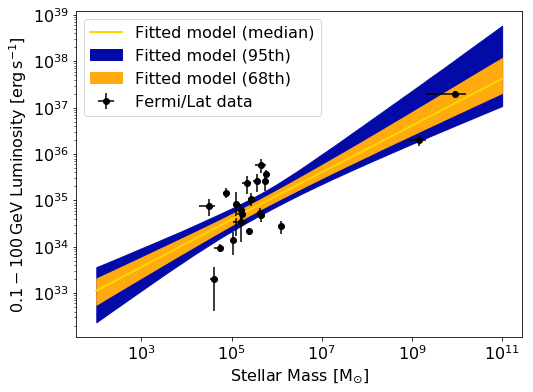

In [451]:
plt.errorbar(masses_all,L_GeV_all,xerr=masses_all_err,yerr=L_GeV_all_err,fmt='ko',label='Fermi/Lat data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Fitted model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='Fitted model (68th)')


fit_model = np.median(chain_sysxy_fam['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='Fitted model (median)')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')
plt.legend()

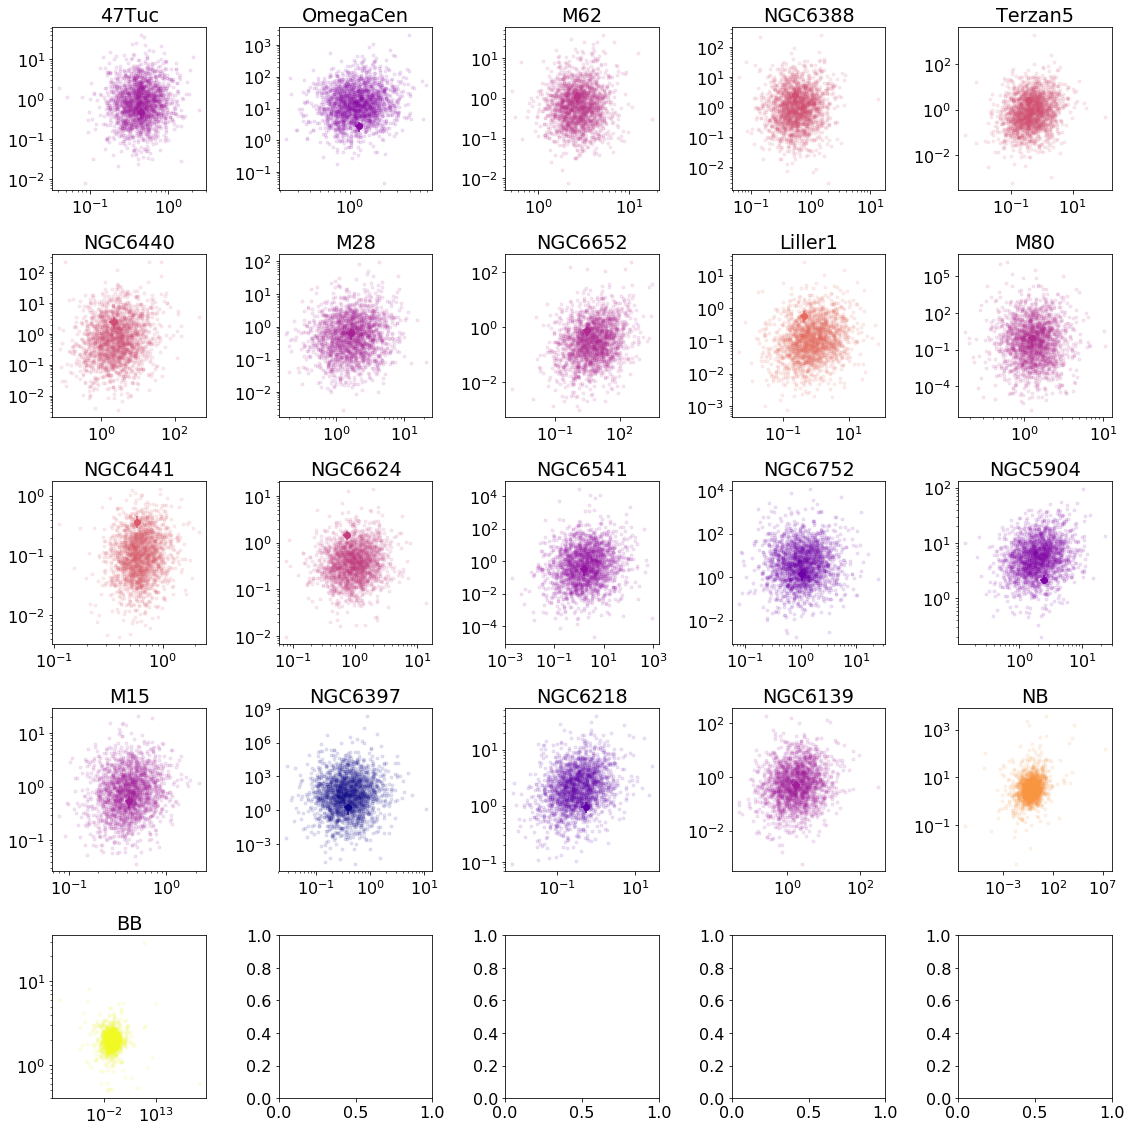

In [167]:
fig,axes = plt.subplots(5,5,figsize=(16,16))

cnt = 0
for i in range(5):
    for j in range(5):
        if (cnt < len(masses_all)):
            axes[i,j].plot(chain_sysxy_fam['ppc_x'][::10,cnt]/mass_scl[cnt],
                           chain_sysxy_fam['ppc_y'][::10,cnt]/Lumi_scl[cnt],'.',alpha=0.1,color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].errorbar(masses_all[cnt]/mass_scl[cnt],
                               L_GeV_all[cnt]/Lumi_scl[cnt],
                               xerr=masses_all_err[cnt]/mass_scl[cnt],
                               yerr=L_GeV_all_err[cnt]/Lumi_scl[cnt],fmt='o',color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].set_title(names_all[cnt])
            axes[i,j].set_yscale('log')
            axes[i,j].set_xscale('log')
            cnt += 1
#plt.xlabel('x')
#plt.ylabel('y')
plt.tight_layout()

(1e+32, 1e+38)

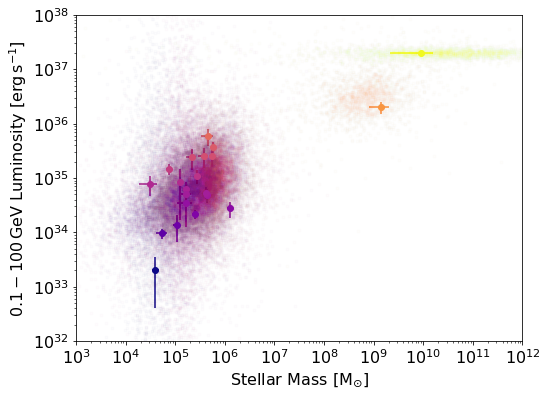

In [168]:
for i in range(len(masses_all)):
    #plt.loglog(10**chain_sysxy_fam['lgx_latent'][::10,i],10**chain_sysxy_fam['lgy_true'][::10,i],'.',alpha=0.01,color=colors[i])
    plt.loglog(chain_sysxy_fam['ppc_x'][::10,i],chain_sysxy_fam['ppc_y'][::10,i],'.',alpha=0.01,color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[i]))))
    plt.errorbar(masses_all[i],L_GeV_all[i],xerr=masses_all_err[i],yerr=L_GeV_all_err[i],fmt='o',color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.xlim(1e3,1e12)
plt.ylim(1e32,1e38)

<h3>Now, all the points are nice predicted. Still, certain objects show very large uncertainties in what would actually be expected. This also results in large uncertainties in the predicted 511 keV flux:</h3>

(1e-09, 0.01)

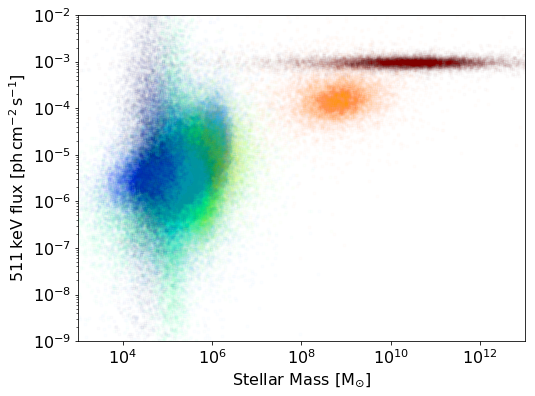

In [169]:
for i in range(len(masses_all)):
    plt.loglog(chain_sysxy_fam['ppc_x'][::2,i],chain_sysxy_fam['five11_flux_sample'][::2,i],'.',alpha=0.01,color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

plt.xlim(1e3,1e13)
plt.ylim(1e-9,1e-2)

Text(0, 0.5, 'Posterior PDF [a.u.]')

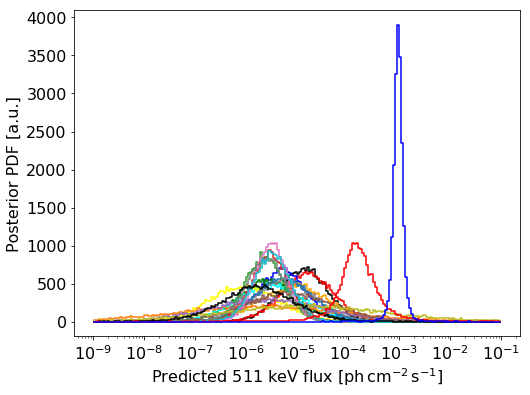

In [170]:
nbins = 200
five11_flux_edges_fam = np.logspace(-9,-1,nbins+1)
five511_flux_bins_fam = (five11_flux_edges_fam[0:-1]+five11_flux_edges_fam[1:])/2
gc511_pdfs_fam = np.zeros((len(masses_all),nbins))
for i in range(len(masses_all)):
    gc511_pdfs_fam[i,:] = (np.histogram(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),bins=np.logspace(-9,-1,nbins+1)))[0]
for i in range(len(masses_all)):
    plt.step(five511_flux_bins_fam,gc511_pdfs_fam[i,:],where='mid')
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
#plt.yscale('log')

<h3>Comparing the sample of 19 globular cluster to get the correlation, to the 154 globular clusters to get a total flux of the population:</h3>

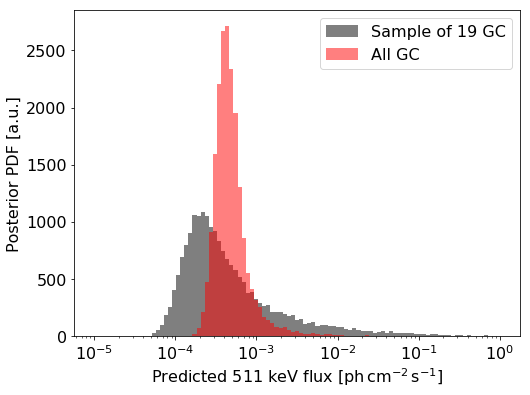

In [454]:
plt.hist(chain_sysxy_fam['GC511_flux_total_sample'],np.logspace(-5,0,100),alpha=0.5,label='Sample of 19 GC');
plt.hist(chain_sysxy_fam['GC511_flux_total_GC'],np.logspace(-5,0,100),alpha=0.5,label='All GC');
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
plt.legend()

<h3>Calculating all the values/prediction in more detail</h3>

In [196]:
gc511_sysxy_fam = []
gc511_sysxy_fam_errlo = []
gc511_sysxy_fam_errhi = []
for i in range(len(masses_all)):
    gc511_sysxy_fam.append(np.percentile(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),50))
    gc511_sysxy_fam_errhi.append(np.percentile(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),50+68.3/2) - 
                              np.percentile(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),50))
    gc511_sysxy_fam_errlo.append(np.percentile(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),50) - 
                              np.percentile(chain_sysxy_fam['five11_flux_sample'][:,i].ravel(),50-68.3/2))
gc511_sysxy_fam = np.array(gc511_sysxy_fam).reshape(len(gc511_sysxy_fam))
gc511_sysxy_fam_errlo = np.array(gc511_sysxy_fam_errlo).reshape(len(gc511_sysxy_fam))
gc511_sysxy_fam_errhi = np.array(gc511_sysxy_fam_errhi).reshape(len(gc511_sysxy_fam))

In [197]:
Nsrc = np.arange(len(masses_all)) # number of sources (array)

(3e-08, 0.03)

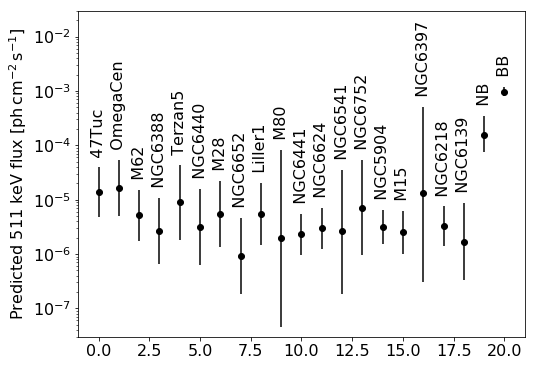

In [211]:
plt.errorbar(Nsrc,gc511_sysxy_fam,yerr=(gc511_sysxy_fam_errlo,gc511_sysxy_fam_errhi),fmt='o')
for i in range(len(Nsrc)):
    plt.text(Nsrc[i],gc511_sysxy_fam[i]+gc511_sysxy_fam_errhi[i],'  '+names_all[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center')
#plt.ylim(-8,-2)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.yscale('log')
plt.ylim(3e-8,3e-2)

<h3>From the sample of 19, OmegaCen would show the largest predicted flux, as expecte from the highest stellar mass wtf. to the distance of the GC</h3>

<h3>Now the. total flux prediction for the populations:</h3>

In [455]:
GCmap511_lo = np.percentile(chain_sysxy_fam['GC511_flux_total_GC'],50-68.3/2)
GCmap511_tot = np.percentile(chain_sysxy_fam['GC511_flux_total_GC'],50)
GCmap511_up = np.percentile(chain_sysxy_fam['GC511_flux_total_GC'],50+68.3/2)
GCmap511_errlo = GCmap511_lo - GCmap511_tot
GCmap511_errhi = GCmap511_up - GCmap511_tot

GCmap511_lo3 = np.percentile(chain_sysxy_fam['GC511_flux_total_GC'],50-99.73/2)
GCmap511_up3 = np.percentile(chain_sysxy_fam['GC511_flux_total_GC'],50+99.73/2)
GCmap511_errlo3 = GCmap511_lo3 - GCmap511_tot
GCmap511_errhi3 = GCmap511_up3 - GCmap511_tot

print('Expected 511 keV flux from globular clusters (from L_GeV - M_star relation) [1e-4 ph/cm2/s] (1sigma): ',
      np.round(GCmap511_tot*1e4,2),np.round(GCmap511_errlo*1e4,2),np.round(GCmap511_errhi*1e4,2))
print('Expected 511 keV flux from globular clusters (from L_GeV - M_star relation) [1e-4 ph/cm2/s] (3sigma): ',
      np.round(GCmap511_tot*1e4,2),np.round(GCmap511_errlo3*1e4,2),np.round(GCmap511_errhi3*1e4,2))

Expected 511 keV flux from globular clusters (from L_GeV - M_star relation) [1e-4 ph/cm2/s] (1sigma):  4.46 -1.21 2.39
Expected 511 keV flux from globular clusters (from L_GeV - M_star relation) [1e-4 ph/cm2/s] (1sigma):  4.46 -2.64 580.52


<h3>This would readily be measurable with SPI(!), however, also shows a somewhat large range of allowed values: in the 99% percentile, values as small as 1.9e-4 are expected (and also unreasonable high values ~ meaning the model is certainly only a zero-to-first-order expectation</h3>

In [189]:
lgGC_masses = np.log10(Mstar.values)
lgGC_masses_err = ((np.abs(np.log10(Mstar.values) - np.log10(np.abs(Mstar.values-Mstar_err.values))))+(np.abs(np.log10(np.abs(Mstar.values+Mstar_err.values)) - np.log10(Mstar.values)))/2.)

<h3>Example prediction for OmegaCen using the family-systematics-model</h3>

Text(0.5, 1.0, 'NGC_5139, $(   1.6 ^{+  0.6} _{ -0.4} ) \\times 10^{-5}\\,\\mathrm{ph\\,cm^{-2}\\,s^{-1}}$')

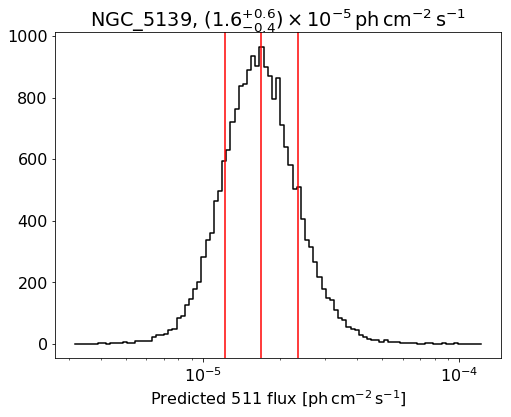

In [464]:
src = 27
prediction_OmegaCen = np.histogram(chain_sysxy_fam['five11_flux_GC'][:,src].ravel(),bins=np.logspace(-5.5,-3.9,100));
plt.step(prediction_OmegaCen[1][0:-1],prediction_OmegaCen[0],where='mid')
plt.xscale('log')
plt.xlabel(r'Predicted 511 flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
median_flux_OmegaCen = np.round(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,src],50),7)
perc68hi_flux_OmegaCen = np.round(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,src],50+68.3/2),7)
perc68lo_flux_OmegaCen = np.round(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,src],50-68.3/2),7)
errlo_flux_OmegaCen = perc68lo_flux_OmegaCen - median_flux_OmegaCen
errhi_flux_OmegaCen = perc68hi_flux_OmegaCen - median_flux_OmegaCen
plt.axvline(median_flux_OmegaCen,color='red')
plt.axvline(perc68hi_flux_OmegaCen,color='red')
plt.axvline(perc68lo_flux_OmegaCen,color='red')
plt.title(names2[src]+', '+str(r'$( %5.3s ^{+%5.3s} _{%5.4s} ) \times 10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$' % (median_flux_OmegaCen*1e5,errhi_flux_OmegaCen*1e5,errlo_flux_OmegaCen*1e5)))

<h3>And all of them:</h3>

Text(0, 0.5, 'Posterior PDF [a.u.]')

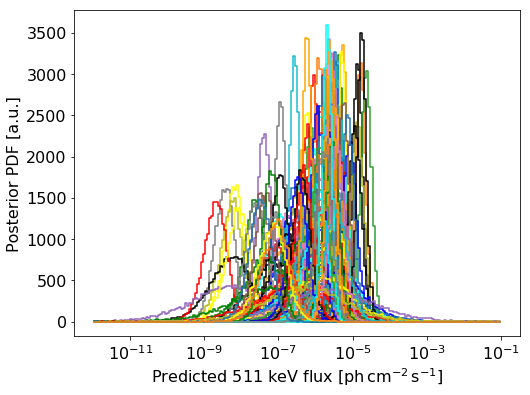

In [465]:
nbins = 200
five11_flux_edges_fam_all = np.logspace(-12,-1,nbins+1)
five511_flux_bins_fam_all = (five11_flux_edges_fam_all[0:-1]+five11_flux_edges_fam_all[1:])/2
gc511_pdfs_fam_all = np.zeros((len(Mstar.values),nbins))
for i in range(len(Mstar.values)):
    gc511_pdfs_fam_all[i,:] = (np.histogram(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),bins=np.logspace(-12,-1,nbins+1)))[0]
for i in range(len(Mstar.values)):
    plt.step(five511_flux_bins_fam_all,gc511_pdfs_fam_all[i,:],where='mid')
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
#plt.yscale('log')

<h3>How does this look like in the flux plot (each colour is a different GC):</h3>

In [406]:
colors_m = colors.PowerNorm(1,vmin=np.min(Mstar),vmax=np.max(Mstar))

(1e-10, 0.001)

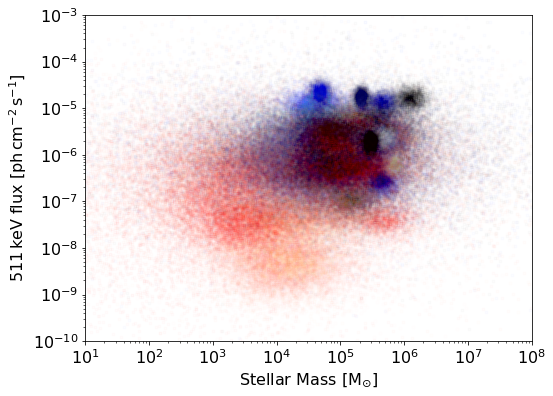

In [519]:
for i in range(len(Mstar.values)):
    plt.loglog(chain_sysxy_fam['GC_ppc_x'][::10,i],chain_sysxy_fam['five11_flux_GC'][::10,i],'.',alpha=0.01,color=plt.cm.flag(colors_m(Mstar[i])))
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

plt.xlim(1e1,1e8)
plt.ylim(1e-10,1e-3)

<h3>And calculating the expectation (median) value and with 68th percentile to make a prediction for the total map</h3>

In [408]:
gc511_sysxy_fam_all = []
gc511_sysxy_fam_all_errlo = []
gc511_sysxy_fam_all_errhi = []
for i in range(len(Mstar)):
    gc511_sysxy_fam_all.append(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),50))
    gc511_sysxy_fam_all_errhi.append(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),50+68.3/2) - 
                              np.percentile(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),50))
    gc511_sysxy_fam_all_errlo.append(np.percentile(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),50) - 
                              np.percentile(chain_sysxy_fam['five11_flux_GC'][:,i].ravel(),50-68.3/2))
gc511_sysxy_fam_all = np.array(gc511_sysxy_fam_all).reshape(len(gc511_sysxy_fam_all))
gc511_sysxy_fam_all_errlo = np.array(gc511_sysxy_fam_all_errlo).reshape(len(gc511_sysxy_fam_all))
gc511_sysxy_fam_all_errhi = np.array(gc511_sysxy_fam_all_errhi).reshape(len(gc511_sysxy_fam_all))

In [227]:
NsrcGC = np.arange(len(Mstar.values))

(5e-10, 0.0001)

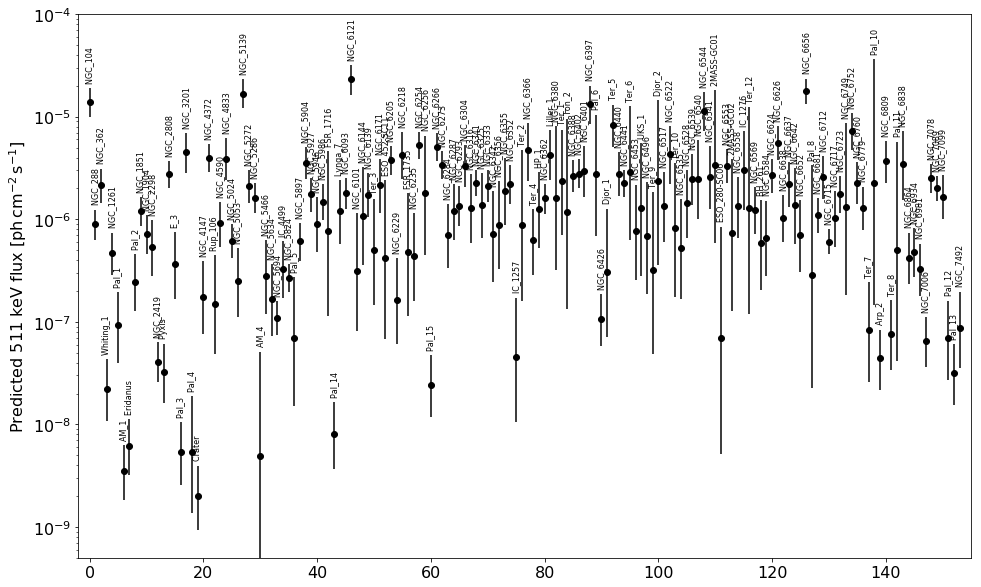

In [232]:
plt.figure(figsize=(16,10))
plt.errorbar(np.arange(len(Mstar.values)),gc511_sysxy_fam_all,
             yerr=(gc511_sysxy_fam_all_errlo,gc511_sysxy_fam_all_errhi),fmt='o')
for i in range(len(Mstar.values)):
    plt.text(NsrcGC[i],gc511_sysxy_fam_all[i]+gc511_sysxy_fam_all_errhi[i],'  '+names2[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
#plt.ylim(-9,-3)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.xlim(-2,155)
plt.yscale('log')
plt.ylim(5e-10,1e-4)

<h3>Here, not OmegaCen (NGC 5139) is the highest point, but NGC 6121, being closer (2.2 kpc, compared to 5.2 kpc), and also massive!</h3>

<h3>How does the 511 keV data correlate with stellar mass (need to calculate the luminosity first, as otherwise, flux makes no sense because of distance</h3>

In [233]:
print((0.8e-4 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(8.2*u.kpc)**2).to(u.erg/u.s))
print((0.12e-4 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(8.2*u.kpc)**2).to(u.erg/u.s))
print((0.96e-3 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(8.2*u.kpc)**2).to(u.erg/u.s))
print((0.07e-3 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(8.2*u.kpc)**2).to(u.erg/u.s))
print((1.7e-3 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(10.0*u.kpc)**2).to(u.erg/u.s))
print((0.3e-3 * 511*u.keV/u.s/u.cm**2 * 4*np.pi*(10.0*u.kpc)**2).to(u.erg/u.s))

5.269385068914695e+35 erg / s
7.904077603372042e+34 erg / s
6.323262082697632e+36 erg / s
4.610711935300357e+35 erg / s
1.6652949541112024e+37 erg / s
2.93875580137271e+36 erg / s


In [234]:
masses511 = np.concatenate([masses_all[19:21],np.array([5e10])])
masses511_err = np.concatenate([masses_all_err[19:21],np.array([1e10])])
L511 = np.array([5.3e35,6.3e36,1.7e37])#np.array([0.8e-4,0.96e-3,1.7e-3])
L511_err = np.array([7.9e34,4.6e35,2.9e36]) #np.array([0.12e-4,0.07e-3,0.3e-3])

<h3>To get a rough starting point for where to set the priors, do the maximum likelihood fit</h3>

In [235]:
import scipy.optimize as optimise

In [243]:
nll = lambda *args: -lnlike(*args)
result511 = optimise.minimize(nll, (26, 1), args=(masses511, L511, L511_err),)
result511

      fun: 13.2802520008483
 hess_inv: array([[ 0.16463873, -0.01654065],
       [-0.01654065,  0.00166972]])
      jac: array([2.38418579e-07, 2.62260437e-06])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 7
     njev: 14
   status: 0
  success: True
        x: array([26.77583365,  0.99133152])

Text(0, 0.5, '$511\\,\\mathrm{keV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

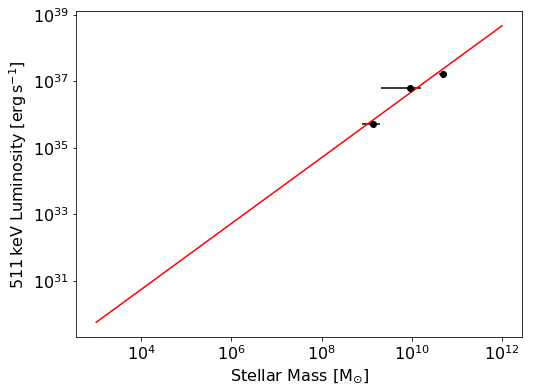

In [469]:
plt.errorbar(masses511,L511,xerr=masses511_err,yerr=L511_err,fmt='o')
plt.plot(mm,powerlaw_correlation(mm,result511.x[0],result511.x[1]))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

<h3>And then fit</h3>

In [254]:
# 
# dictionary for data set and prior
data511 = dict(N = 3,
            x_obs = masses511,
            y_obs = L511,
            sigma_x = masses511_err,
            sigma_y = L511_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 26.8,
            sigma_lgNorm = 2.0,
            mu_alpha = 1,
            sigma_alpha = 0.5)

In [255]:
# fit the model
fit_pl_511 = model_pl.sampling(data=data511,verbose=True,chains=1,iter=2000,algorithm='HMC')

In [470]:
print(fit_pl_511.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
1 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  26.84    0.03   1.29  24.25  26.03  26.92  27.76  29.11   2551    1.0
alpha    0.97  2.6e-3   0.12   0.75   0.89   0.97   1.05   1.22   2342    1.0

Samples were drawn using HMC at Wed Nov 13 18:09:56 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [257]:
chain_511 = fit_pl_511.extract()

In [258]:
colors2 = colors.PowerNorm(1,vmin=np.min(np.log10(Mstar.values)),vmax=np.max(np.log10(Mstar.values)))

In [259]:
"""random_idx_save = np.copy(random_idx)"""

'random_idx_save = np.copy(random_idx)'

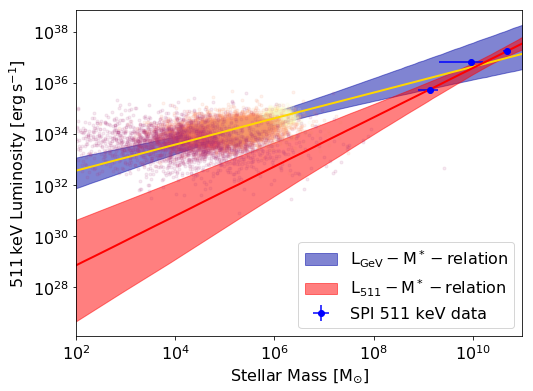

In [471]:
random_idx_save = np.random.choice(len(masses2.values),size=10)

#plt.errorbar(Mstar.values,np.median(chain_sysxy_fam['five11_flux_GC'],axis=0),
#             xerr=Mstar_err.values,yerr=np.std(chain_sysxy_fam['five11_flux_GC'],axis=0),fmt='o',alpha=0.1)

for i in range(len(random_idx_save)):
    plt.loglog(chain_sysxy_fam['GC_ppc_x'][::10,random_idx_save[i]],
               chain_sysxy_fam['five11_flux_GC'][::10,random_idx_save[i]]*1.19e44*dist2[random_idx_save[i]]**2/1.2e6,'.',alpha=0.1,
               color=plt.cm.magma(colors2(np.log10(Mstar.values[random_idx_save[i]]))))


plt.errorbar(masses511,L511,
             xerr=masses511_err,yerr=L511_err,fmt='bo',label='SPI 511 keV data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam['powerlaw511'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam['powerlaw511'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=0.5,label=r'$\mathrm{L_{GeV}-M^*}-$relation')

plt.fill_between(x_model,
                np.percentile(chain_511['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_511['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='red',alpha=0.5,label=r'$\mathrm{L_{511}-M^*}-$relation')

fit_model = np.median(chain_sysxy_fam['powerlaw511'],axis=0)
fit_model511 = np.median(chain_511['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold')
plt.plot(x_model,fit_model511,linewidth=2,color='red')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Stellar Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.xlim(1e2,1e11)
#plt.ylim(1e-13,1e-1)

plt.legend()


<h3>The models do not necessarily predict the same values for the globular clusters, however, the uncertainties for individual sources (scattered points) do fall into the red reagion for the 511 keV data only</h3>

<h3>Now let's make a map template out of that:</h3>

<h3>I choose 0.5 deg pixels, as everything else would not make any sense for SPI (and the fits in the end would take forever):</h3>

In [262]:
binsize = 0.5
map_expect511 = np.zeros((int(180/binsize),int(360/binsize)))

In [263]:
# we define our sky-grid on a regular pix_scl x pix_scl pixel grid
l_arrg = np.linspace(-180,180,(360/binsize)+1)
b_arrg = np.linspace(-90,90,(180/binsize)+1)
L_ARRg, B_ARRg = np.meshgrid(l_arrg,b_arrg)
l_arr = l_arrg[0:-1]+binsize/2
b_arr = b_arrg[0:-1]+binsize/2
L_ARR, B_ARR = np.meshgrid(l_arr,b_arr)

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


In [265]:
map_idx = np.round((gb2+90)/binsize).astype(int),np.round((gl2+180)/binsize).astype(int)

In [275]:
for i in range(len(masses2.values)):
    map_expect511[map_idx[0][i],map_idx[1][i]] = gc511_sysxy_fam_all[i]/((binsize*np.pi/180)*(np.sin(np.deg2rad(b_arr[map_idx[0][i]]+binsize/2)) - np.sin(np.deg2rad(b_arr[map_idx[0][i]]-binsize/2))))

In [487]:
inner_idx = np.where((L_ARR > -65) & (L_ARR < +65) & (B_ARR > -45) & (B_ARR < +45))

Text(0, 0.5, 'Gal. Lat. [deg]')

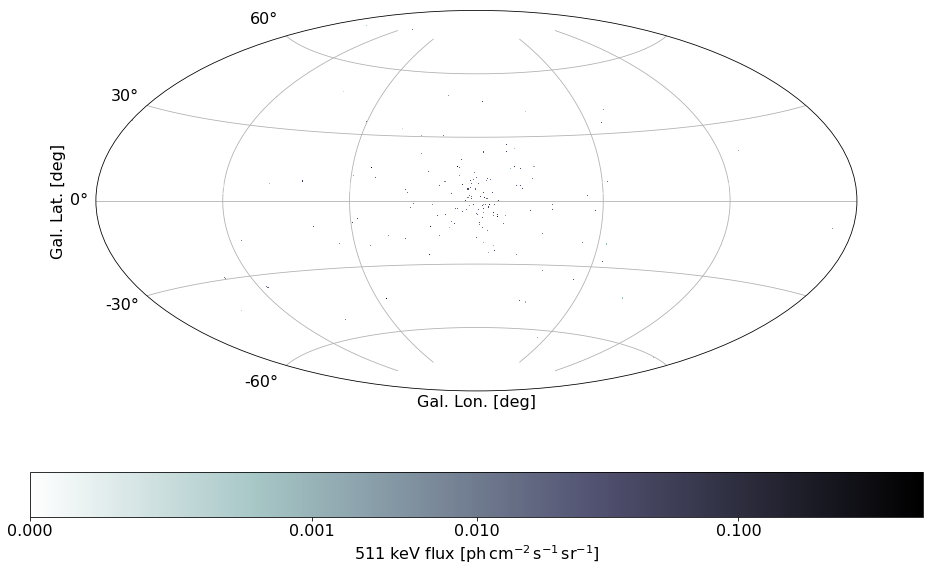

In [489]:
plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
cb = plt.pcolormesh(np.deg2rad(L_ARRg),np.deg2rad(B_ARRg),map_expect511,cmap=cm.bone_r,
                              norm=colors.PowerNorm(0.20,
                                     vmin=map_expect511[inner_idx[0],inner_idx[1]].min()*0,
                                     vmax=map_expect511[inner_idx[0],inner_idx[1]].max()))
plt.colorbar(cb,orientation='horizontal',
             label=r'511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',ticks=[0,1e-3,1e-2,1e-1,1e0,2])
plt.xticks(ticks=np.deg2rad([-120,-60,60,120]),color='white',alpha=0.5)
plt.yticks(ticks=np.deg2rad([-60,-30,0,30,60]))
plt.grid(True)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')

<h3>Yes, there are points, but hard to distinguish there fluxes</h3>

<h3>Now, what could this look like compared to the diffuse emission? Let's use the boxy bulge and nuclear stellar cluster template (and a Gaussian-shaped disk) to have a look.<br>
    These components will be included in the fit with SPI data in the end</h3>

In [478]:
from astropy import wcs

In [280]:
from matplotlib import ticker, cm

In [281]:
from astropy.visualization import *

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



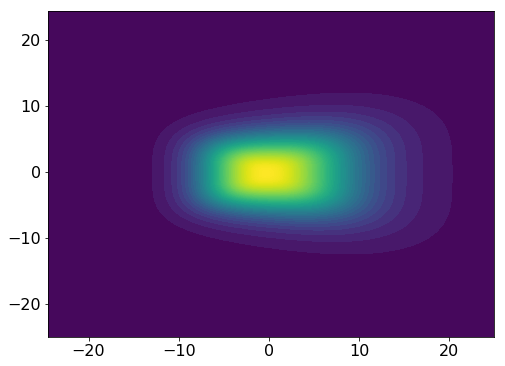

In [490]:
with fits.open('Boxy_Bulge_50x50deg_Normalized.fits') as fBB:
    BB = fBB[0].data
    wBB = wcs.WCS(fBB[0].header)
    nx1BB = wBB._naxis1
    nx2BB = wBB._naxis2
    XBB,YBB = np.meshgrid(np.arange(nx1BB),np.arange(nx2BB))
    lonsBB, latsBB = wBB.wcs_pix2world(XBB.ravel(),YBB.ravel(),0)
    lonsBB = lonsBB.reshape(nx2BB,nx1BB)
    latsBB = latsBB.reshape(nx2BB,nx1BB)
    lonsBB[lonsBB > 180] -= 360

normBB = ImageNormalize(BB, interval=MinMaxInterval(),stretch=AsinhStretch())
plt.contourf(lonsBB,latsBB,BB,levels=100,norm=normBB)

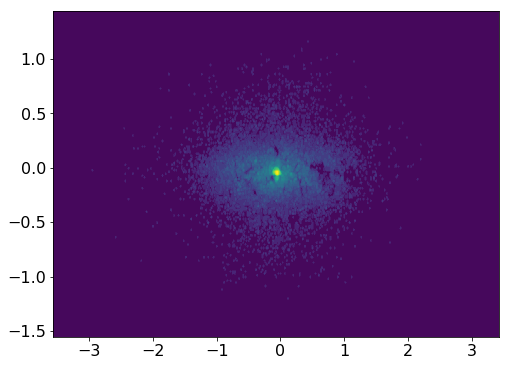

In [491]:
with fits.open('Stellar_profile_Normalized.fits') as fNB:
    NB = fNB[0].data
    wNB = wcs.WCS(fNB[0].header)
    nx1NB = wNB._naxis1
    nx2NB = wNB._naxis2
    XNB,YNB = np.meshgrid(np.arange(nx1NB),np.arange(nx2NB))
    lonsNB, latsNB = wNB.wcs_pix2world(XNB.ravel(),YNB.ravel(),0)
    lonsNB = lonsNB.reshape(nx2NB,nx1NB)
    latsNB = latsNB.reshape(nx2NB,nx1NB)
    lonsNB[lonsNB > 180] -= 360
    lonsNB[lonsNB < -180] += 360

normNB = ImageNormalize(NB, interval=MinMaxInterval(),stretch=AsinhStretch())
plt.contourf(lonsNB,latsNB,NB,levels=100,norm=normNB)

<h3>Interpolate to the complete grid where we defined the GC map...</h3>

In [493]:
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import interp2d

In [494]:
blaBB = interp2d(lonsBB[0,:],latsBB[:,0],BB,bounds_error=False,fill_value=0)
blaNB = interp2d(lonsNB[0,:],latsNB[:,0],NB,bounds_error=False,fill_value=0)

<h3>Making a 2D Gaussian for the disk (note that this is an approximation for how a 2D Gaussian on a disk is actually described, and may not be appropriate for large values of sigma_b)</h3>

In [495]:
def Gaussian2D(ll,bb,A0,l0,b0,sl,sb,binsize=5):
    shape = np.exp(-(ll-l0)**2/(2*sl**2)-(bb-b0)**2/(2*sb**2))
    norm = np.sum(shape*(binsize*np.pi/180)*(np.sin(np.deg2rad(bb+binsize/2)) - np.sin(np.deg2rad(bb-binsize/2))))
    val = A0*shape/norm
    return val

In [497]:
BBsky = blaBB(l_arr,b_arr)
NBsky = blaNB(l_arr,b_arr)
DISKsky = Gaussian2D(L_ARR,B_ARR,1,0,0,60,10.5,binsize=binsize)

BBskynorm = np.sum(BBsky*(binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2))))
NBskynorm = np.sum(NBsky*(binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2))))
DISKskynorm = np.sum(DISKsky*(binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2))))

# doing some cross-checks if the binsize is too large to actually have more than one pixel covered for the galactic centre source

print(BBskynorm,NBskynorm,DISKskynorm)

if (np.sum(NBsky) == 0):
    NBsky = np.zeros((int(180/binsize),int(360/binsize)))
    NBsky[int((180/binsize)/2+0),int((360/binsize)/2+0)] = 1/4
    NBsky[int((180/binsize)/2+0),int((360/binsize)/2+1)] = 1/4
    NBsky[int((180/binsize)/2+1),int((360/binsize)/2+0)] = 1/4
    NBsky[int((180/binsize)/2+1),int((360/binsize)/2+1)] = 1/4
    NBskynorm = 1
    
print(BBskynorm,np.sum(NBsky),DISKskynorm)

0.9970417060025257 0.8672375407900563 1.0
0.9970417060025257 11388.115825047298 1.0


<h3>Normalisation for the GC template map should be the same as the sum of all predicted fluxes for GCs...</h3>

In [498]:
map_expect511norm = np.sum(map_expect511*(binsize*np.pi/180)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2))))
map_expect511norm

0.0003176279166895207

In [499]:
np.sum(gc511_sysxy_fam_all)

0.0003219201595490263

<h3>Looks like it is, within some margin (?)</h3>

In [296]:
fluxes511 = np.array([0.8e-4,0.96e-3,1.7e-3])
fluxes511_err = np.array([0.12e-4,0.07e-3,0.3e-3])

Text(0, 0.5, 'Gal. Lat. [deg]')

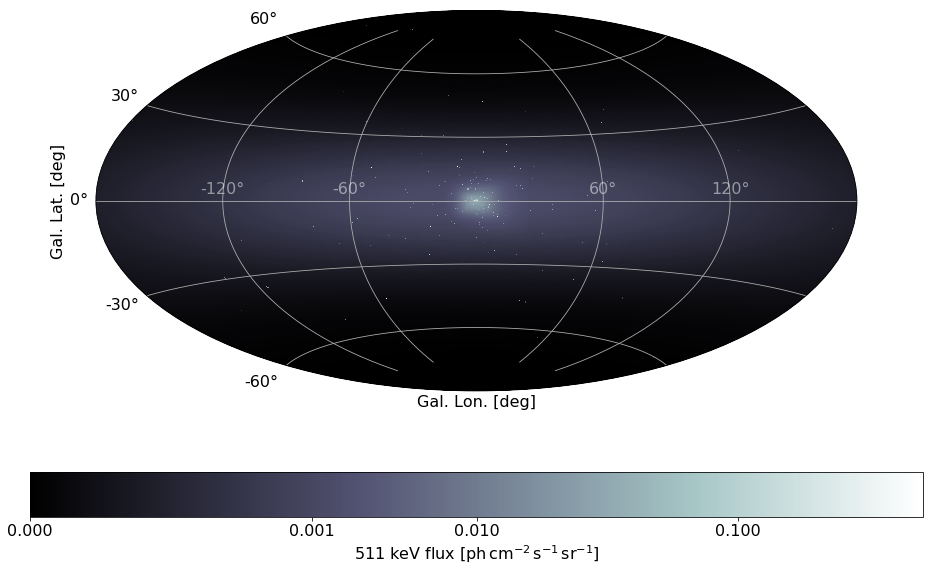

In [500]:
o = 1e0
map_total511 = map_expect511 + NBsky/NBskynorm*fluxes511[0] + BBsky/BBskynorm*fluxes511[1] + 1*DISKsky/DISKskynorm*fluxes511[2]

plt.figure(figsize=(16,10))
plt.subplot(projection='aitoff')
cb = plt.pcolormesh(np.deg2rad(L_ARRg),np.deg2rad(B_ARRg),map_total511,cmap=cm.bone,
                              norm=colors.PowerNorm(0.20,
                                     vmin=map_total511[inner_idx[0],inner_idx[1]].min()*0,
                                     vmax=map_total511[inner_idx[0],inner_idx[1]].max()*o))
plt.colorbar(cb,orientation='horizontal',
             label=r'511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',ticks=[0,1e-3,1e-2,1e-1,1e0,2])
plt.xticks(ticks=np.deg2rad([-120,-60,60,120]),color='white',alpha=0.5)
plt.yticks(ticks=np.deg2rad([-60,-30,0,30,60]))
plt.grid(True)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')

<h3>This is one(!) realisation of the GC template from the L_GeV - M* - correlation on top of the expected (measured) diffuse emission.<br>
    We will have to draw several of these GC template maps to get an uncertainty for the significance of this component, and if this approach is reliable (later)</h3>

<h3>Close-up view of the central region:</h3>

Text(0, 0.5, 'Gal. Lat. [deg]')

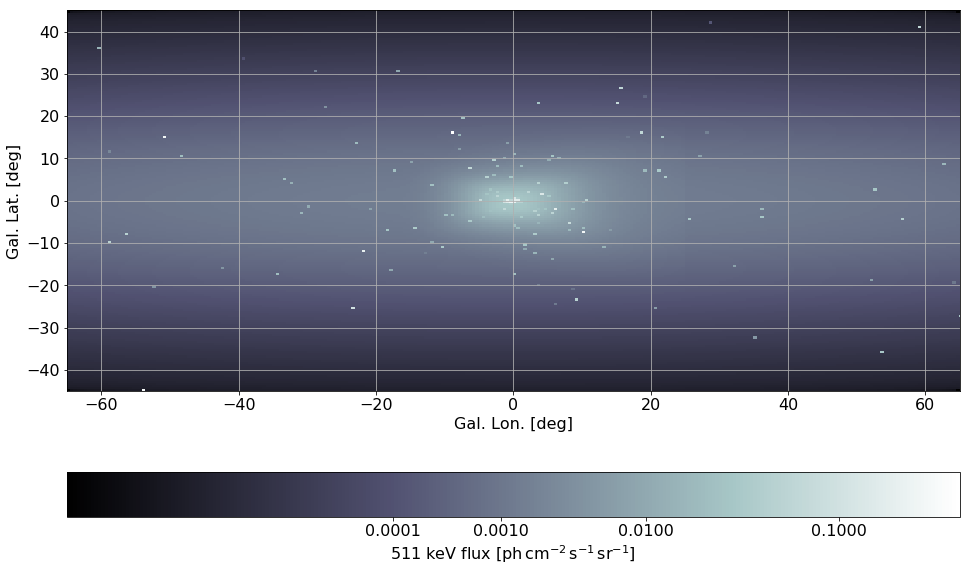

In [300]:
o = 1e0
plt.figure(figsize=(16,10))
cb = plt.pcolormesh(L_ARRg,B_ARRg,map_total511*o,cmap=cm.bone,
               norm=colors.PowerNorm(0.125,
                                     vmin=map_total511[inner_idx[0],inner_idx[1]].min()*o,
                                     vmax=map_total511[inner_idx[0],inner_idx[1]].max()*o))
plt.colorbar(cb,orientation='horizontal',
             label=r'511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',ticks=[0,1e-4,1e-3,1e-2,1e-1,1e0,2])
plt.grid(True)
plt.xlim(-65,65)
plt.ylim(-45,45)
plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')

<h3>Now, what about the same this for dark matter?<br>
    As we used an M/L=1 relation before, we can estimate that the remaining mass could be due to dark matter...<br>
    This will provide of the order of the same correlation because most of the time, the mass-to-light ratios in globular clusters is around 2.<br>
    Then, with propagation of uncertainties, and including the unknown systematic effects, we get much larger errorbar in our expectations:</h3>

In [563]:
M_DM = masses2 - Mstar
M_DM_err = np.sqrt(masses2_err**2 + Mstar_err**2)
print(len(M_DM[M_DM <= 0])/len(M_DM)*100)
M_DM[M_DM <= 0] = np.percentile(M_DM[M_DM > 0],len(M_DM[M_DM <= 0])/len(M_DM)*100) # using the lower percentile level (here 7%) to estimate a lower mass bound for the GCs where the DM mass would be around 0:

6.493506493506493


Text(0.5, 0, 'Globular cluster number')

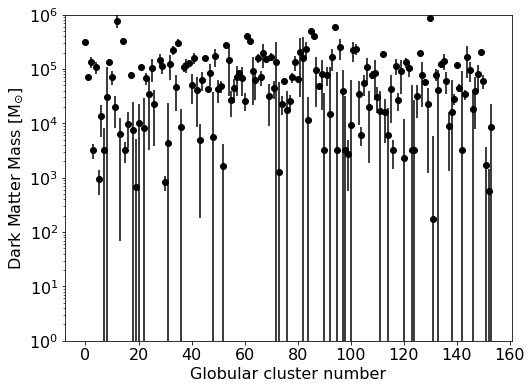

In [564]:
plt.errorbar(NsrcGC,M_DM,yerr=M_DM_err,fmt='o')
plt.yscale('log')
plt.ylim(1e0,1e6)
plt.ylabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.xlabel('Globular cluster number')

<h3>To have a similar correlation for the Dark Matter case, I calculate the mass included in an NFW profile outwards, up to 200 pc for the NB component, and from 200 to 1500 pc for the BB component (the disk is neglected here):</h3>

In [565]:
def rho_NFW(r,rho0,alpha,beta,gamma,R0):
    return rho0/((r/R0)**gamma * (1 + (r/R0)**alpha)**((beta-gamma)/alpha))

In [566]:
rgc = np.arange(1,1e4,1) # radial coordinate

In [567]:
rho_dm = 8e-3 # e.g. 1404.1938. in units of Msun / pc^3
rho_dm_err = 3e-3 # uncertainty for rho_dm
alpha = 1.
beta = 3.
gamma = 1.2
R0 = 20e3

Text(0.5, 0, 'Galactocentric radius [pc]')

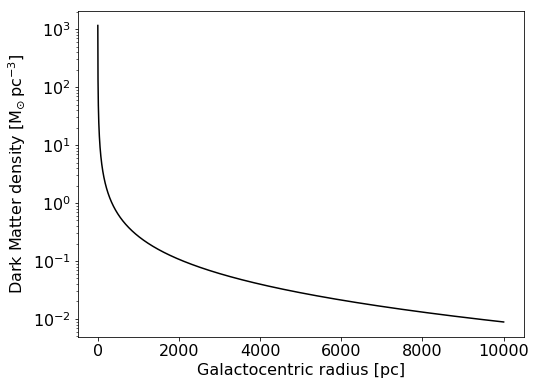

In [568]:
plt.plot(rgc,rho_NFW(rgc,rho_dm,alpha,beta,gamma,R0))
plt.yscale('log')
plt.ylabel(r'Dark Matter density [$\mathrm{M_{\odot}\,pc^{-3}}$]')
plt.xlabel(r'Galactocentric radius [pc]')

In [569]:
from scipy.integrate import trapz

In [570]:
# integration limits
rdx_NB = np.where((rgc <= 200))[0]
rdx_BB = np.where((rgc > 200) & (rgc <= 1500))[0]

In [571]:
# calculating the mass by integrating the NFW density profile radially
M_DM_NB = trapz(rho_NFW(rgc[rdx_NB],rho_dm,alpha,beta,gamma,R0)*4*np.pi*rgc[rdx_NB]**2,x=rgc[rdx_NB])
M_DM_NB_err = trapz(rho_NFW(rgc[rdx_NB],rho_dm_err,alpha,beta,gamma,R0)*4*np.pi*rgc[rdx_NB]**2,x=rgc[rdx_NB])
M_DM_BB = trapz(rho_NFW(rgc[rdx_BB],rho_dm,alpha,beta,gamma,R0)*4*np.pi*rgc[rdx_BB]**2,x=rgc[rdx_BB])
M_DM_BB_err = trapz(rho_NFW(rgc[rdx_BB],rho_dm_err,alpha,beta,gamma,R0)*4*np.pi*rgc[rdx_BB]**2,x=rgc[rdx_BB])

In [572]:
# new array for all masses
mdm_all = np.concatenate([M_DM[idx_GeV].values,np.array([M_DM_NB]),np.array([M_DM_BB])])
mdm_all_err = np.concatenate([M_DM_err[idx_GeV].values,np.array([M_DM_NB_err]),np.array([M_DM_BB_err])])

Text(0, 0.5, '$0.1-100\\,\\mathrm{GeV}$ Luminosity [$\\mathrm{erg\\,s^{-1}}$]')

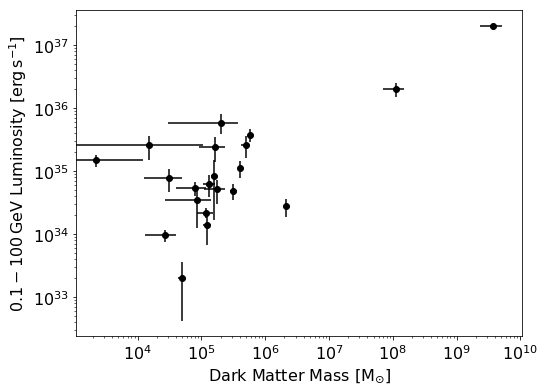

In [573]:
# plot for all objects
plt.errorbar(mdm_all,L_GeV_all,xerr=mdm_all_err,yerr=L_GeV_all_err,fmt='ko')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

<h3>Then we fit the same model, and trying to predict the 511 keV flux from this correlation</h3>

In [574]:
N_obs = len(mdm_all)

# dictionary for data set and prior
data_sysxy_fam_dm = dict(N = N_obs,
            x_obs = mdm_all,
            y_obs = L_GeV_all,
            sigma_x = mdm_all_err,
            sigma_y = L_GeV_all_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 31.5,
            sigma_lgNorm = 1.0,
            mu_alpha = 1.0,
            sigma_alpha = 0.5,
            sys_xy_width_diffuse = 5.0,
            sys_xy_width_GC = 5.0,
            family_idx = family_idx,
            NGC = len(M_DM.values),
            GC_masses = M_DM.values,
            GC_masses_err = M_DM_err.values,
            dist_obs = dist_all,
            GC_dist = dist2.values)


In [575]:
# fit the model
fit_pl_sysxy_fam_dm = model_pl_sysxy_fam.sampling(data=data_sysxy_fam_dm,verbose=True,chains=4,iter=2000,algorithm='HMC')

In [576]:
print(fit_pl_sysxy_fam_dm.stansummary(['lgNorm','alpha','GC511_flux_total_sample','GC511_flux_total_GC','sys_xy_diffuse','sys_xy_GC']))

Inference for Stan model: anon_model_3a5363a9a2c3f5560ab382296a02a4fe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm                   31.79  7.5e-3   0.39  30.99  31.55  31.78  32.02  32.59   2691    1.0
alpha                     0.57  1.2e-3   0.06   0.43   0.53   0.57    0.6    0.7   2745    1.0
GC511_flux_total_sample 6.7e-3  2.7e-3   0.17 1.2e-4 2.3e-4 3.9e-4 8.3e-4   0.02   3978    1.0
GC511_flux_total_GC      19.56   10.87 688.42 3.5e-4 5.8e-4 9.6e-4 3.4e-3   1.13   4014    1.0
sys_xy_diffuse            3.32    0.11    3.2   1.05   1.55   2.37   3.86  11.36    893   1.01
sys_xy_GC                 2.97    0.03    0.5   2.14   2.62   2.91   3.25   4.12    352   1.01

Samples were drawn using HMC at Thu Nov 14 15:44:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the 

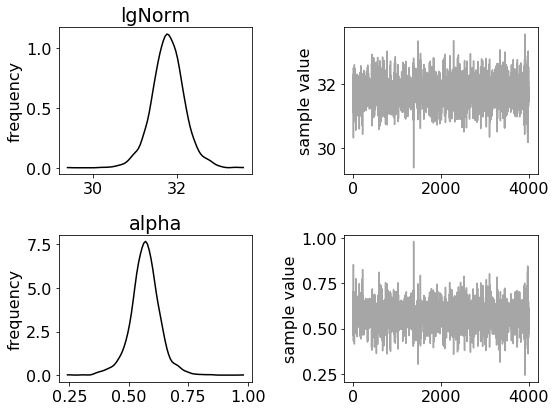

In [577]:
fig = fit_pl_sysxy_fam_dm.plot(['lgNorm','alpha'])
plt.tight_layout()

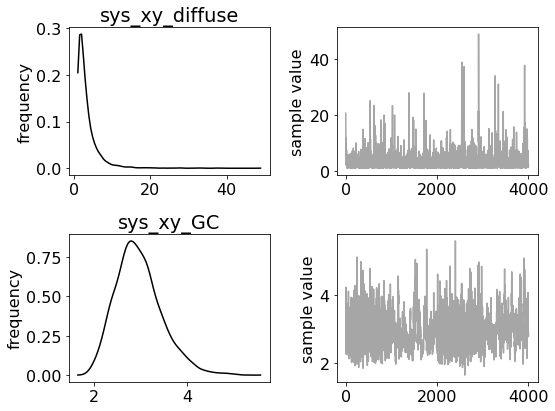

In [578]:
fig = fit_pl_sysxy_fam_dm.plot(['sys_xy_diffuse','sys_xy_GC'])
plt.tight_layout()

/usr/local/lib/python3.7/site-packages/bayescorner/compute_sigma_level.py:21: RuntimeWarning: divide by zero encountered in log
  logL = np.log(L)


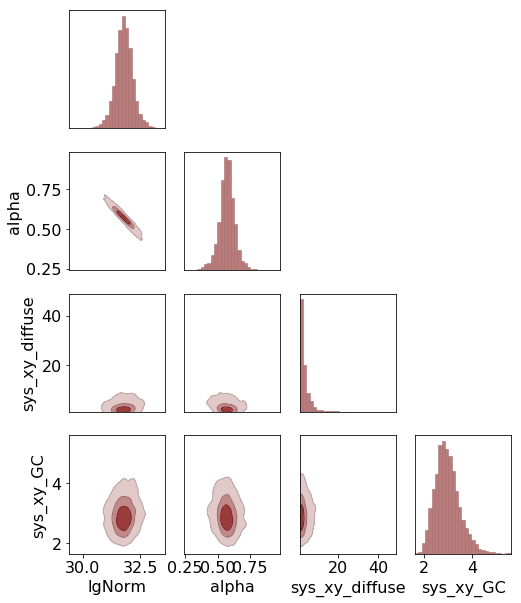

In [579]:
chain_sysxy_fam_dm = fit_pl_sysxy_fam_dm.extract()
fig = bayescorner(params=[chain_sysxy_fam_dm['alpha'],
                          chain_sysxy_fam_dm['sys_xy_diffuse'],
                          chain_sysxy_fam_dm['sys_xy_GC'],
                          chain_sysxy_fam_dm['lgNorm']],
                 param_names=['alpha','sys_xy_diffuse','sys_xy_GC','lgNorm'])

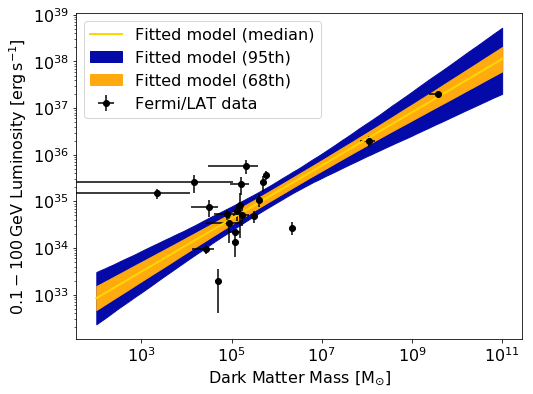

In [580]:
plt.errorbar(mdm_all,L_GeV_all,xerr=mdm_all_err,yerr=L_GeV_all_err,fmt='ko',label='Fermi/LAT data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam_dm['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam_dm['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='Fitted model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam_dm['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam_dm['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='Fitted model (68th)')

fit_model = np.median(chain_sysxy_fam_dm['powerlaw'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='Fitted model (median)')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.legend()

<h3>Again, checking the fit, and avualting the predictions ...</h3>

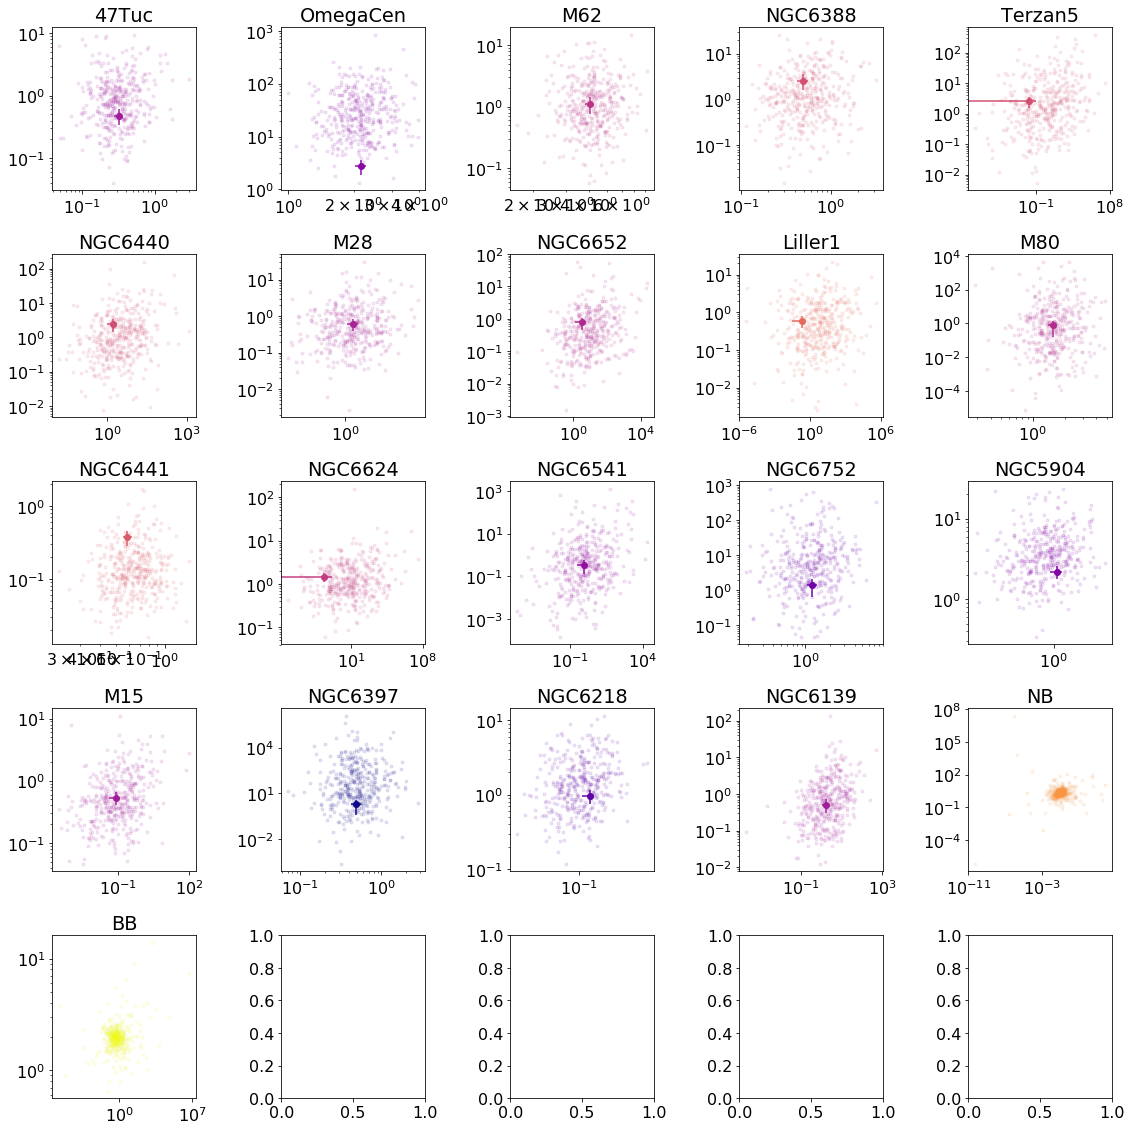

In [581]:
fig,axes = plt.subplots(5,5,figsize=(16,16))

cnt = 0
for i in range(5):
    for j in range(5):
        if (cnt < len(mdm_all)):
            axes[i,j].plot(chain_sysxy_fam_dm['ppc_x'][::10,cnt]/mass_scl[cnt],
                           chain_sysxy_fam_dm['ppc_y'][::10,cnt]/Lumi_scl[cnt],'.',alpha=0.1,color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].errorbar(mdm_all[cnt]/mass_scl[cnt],
                               L_GeV_all[cnt]/Lumi_scl[cnt],
                               xerr=mdm_all_err[cnt]/mass_scl[cnt],
                               yerr=L_GeV_all_err[cnt]/Lumi_scl[cnt],fmt='o',color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[cnt]))))
            axes[i,j].set_title(names_all[cnt])
            axes[i,j].set_yscale('log')
            axes[i,j].set_xscale('log')
            cnt += 1
plt.tight_layout()

(1e+32, 1e+38)

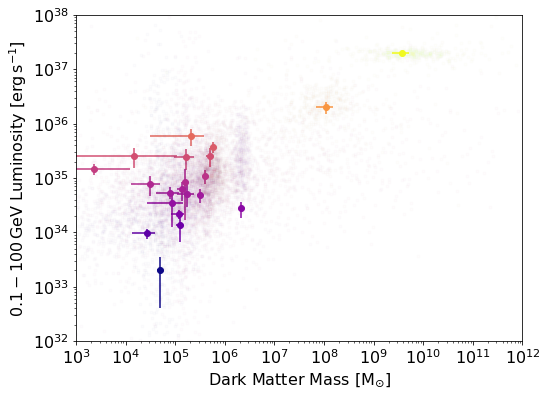

In [582]:
for i in range(len(mdm_all)):
    plt.loglog(chain_sysxy_fam_dm['ppc_x'][::10,i],chain_sysxy_fam_dm['ppc_y'][::10,i],'.',alpha=0.01,color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[i]))))
    plt.errorbar(mdm_all[i],L_GeV_all[i],xerr=mdm_all_err[i],yerr=L_GeV_all_err[i],fmt='o',color=plt.cm.plasma(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$0.1-100\,\mathrm{GeV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.xlim(1e3,1e12)
plt.ylim(1e32,1e38)

(1e-09, 0.01)

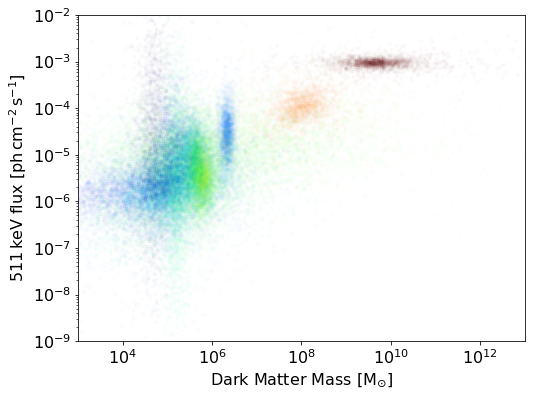

In [583]:
for i in range(len(mdm_all)):
    plt.loglog(chain_sysxy_fam_dm['ppc_x'][::2,i],chain_sysxy_fam_dm['five11_flux_sample'][::2,i],'.',alpha=0.01,color=plt.cm.jet(colors_all(np.log10(L_GeV_all[i]))))
plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

plt.xlim(1e3,1e13)
plt.ylim(1e-9,1e-2)

Text(0, 0.5, 'Posterior PDF [a.u.]')

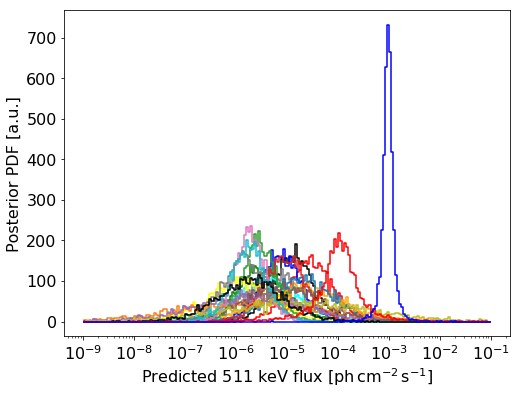

In [584]:
nbins = 200
five11_flux_edges_fam_dm = np.logspace(-9,-1,nbins+1)
five511_flux_bins_fam_dm = (five11_flux_edges_fam_dm[0:-1]+five11_flux_edges_fam_dm[1:])/2
gc511_pdfs_fam_dm = np.zeros((len(mdm_all),nbins))
for i in range(len(mdm_all)):
    gc511_pdfs_fam_dm[i,:] = (np.histogram(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),bins=np.logspace(-9,-1,nbins+1)))[0]
for i in range(len(mdm_all)):
    plt.step(five511_flux_bins_fam_dm,gc511_pdfs_fam_dm[i,:],where='mid')
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
#plt.yscale('log')

In [585]:
gc511_sysxy_fam_dm = []
gc511_sysxy_fam_dm_errlo = []
gc511_sysxy_fam_dm_errhi = []
for i in range(len(masses_all)):
    gc511_sysxy_fam_dm.append(np.percentile(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),50))
    gc511_sysxy_fam_dm_errhi.append(np.percentile(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),50+68.3/2) - 
                              np.percentile(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),50))
    gc511_sysxy_fam_dm_errlo.append(np.percentile(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),50) - 
                              np.percentile(chain_sysxy_fam_dm['five11_flux_sample'][:,i].ravel(),50-68.3/2))
gc511_sysxy_fam_dm = np.array(gc511_sysxy_fam_dm).reshape(len(gc511_sysxy_fam_dm))
gc511_sysxy_fam_dm_errlo = np.array(gc511_sysxy_fam_dm_errlo).reshape(len(gc511_sysxy_fam_dm))
gc511_sysxy_fam_dm_errhi = np.array(gc511_sysxy_fam_dm_errhi).reshape(len(gc511_sysxy_fam_dm))

(5e-08, 0.01)

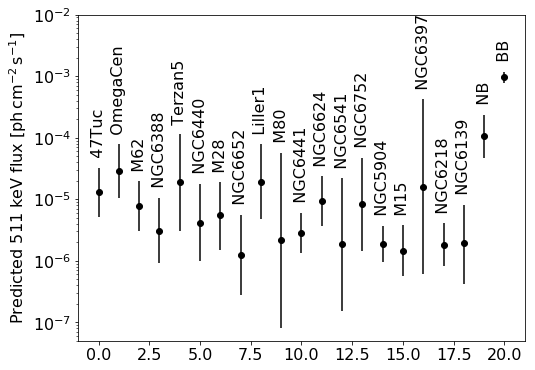

In [586]:
plt.errorbar(Nsrc,gc511_sysxy_fam_dm,yerr=(gc511_sysxy_fam_dm_errlo,gc511_sysxy_fam_dm_errhi),fmt='o')
for i in range(len(Nsrc)):
    plt.text(Nsrc[i],gc511_sysxy_fam_dm[i]+gc511_sysxy_fam_dm_errhi[i],'  '+names_all[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center')
#plt.ylim(-8,-2)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.yscale('log')
plt.ylim(5e-8,1e-2)

<h3>Comparing the M* relation to the DM relation: of course, we get about the same predictions within the uncertainties</h3>

(5e-08, 0.01)

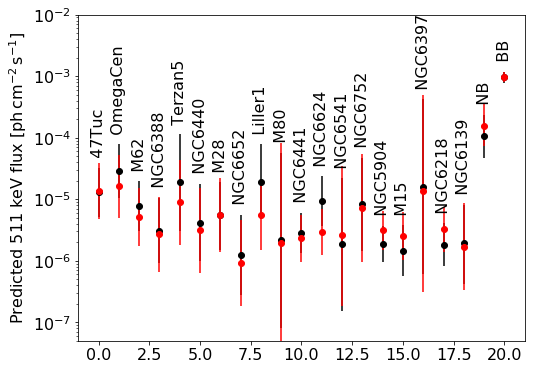

In [587]:
plt.errorbar(Nsrc,gc511_sysxy_fam_dm,yerr=(gc511_sysxy_fam_dm_errlo,gc511_sysxy_fam_dm_errhi),fmt='ko')
plt.errorbar(Nsrc,gc511_sysxy_fam,yerr=(gc511_sysxy_fam_errlo,gc511_sysxy_fam_errhi),fmt='ro')
for i in range(len(Nsrc)):
    plt.text(Nsrc[i],gc511_sysxy_fam_dm[i]+gc511_sysxy_fam_dm_errhi[i],'  '+names_all[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center')
#plt.ylim(-8,-2)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.yscale('log')
plt.ylim(5e-8,1e-2)

In [589]:
GCmap_dm_511_lo = np.percentile(chain_sysxy_fam_dm['GC511_flux_total_GC'],50-68.3/2)
GCmap_dm_511_tot = np.percentile(chain_sysxy_fam_dm['GC511_flux_total_GC'],50)
GCmap_dm_511_up = np.percentile(chain_sysxy_fam_dm['GC511_flux_total_GC'],50+68.3/2)
GCmap_dm_511_errlo = GCmap_dm_511_lo - GCmap_dm_511_tot
GCmap_dm_511_errhi = GCmap_dm_511_up - GCmap_dm_511_tot

GCmap_dm_511_lo3 = np.percentile(chain_sysxy_fam_dm['GC511_flux_total_GC'],50-99.73/2)
GCmap_dm_511_up3 = np.percentile(chain_sysxy_fam_dm['GC511_flux_total_GC'],50+99.73/2)
GCmap_dm_511_errlo3 = GCmap_dm_511_lo3 - GCmap_dm_511_tot
GCmap_dm_511_errhi3 = GCmap_dm_511_up3 - GCmap_dm_511_tot

print('Expected 511 keV flux from globular clusters (from L_GeV - M_DM relation) [1e-4 ph/cm2/s] (1sigma): ',
      np.round(GCmap_dm_511_tot*1e4,2),np.round(GCmap_dm_511_errlo*1e4,2),np.round(GCmap_dm_511_errhi*1e4,2))
print('Expected 511 keV flux from globular clusters (from L_GeV - M_DM relation) [1e-4 ph/cm2/s] (3sigma): ',
      np.round(GCmap_dm_511_tot*1e4,2),np.round(GCmap_dm_511_errlo3*1e4,2),np.round(GCmap_dm_511_errhi3*1e4,2))

Expected 511 keV flux from globular clusters (from L_GeV - M_DM relation) [1e-4 ph/cm2/s] (1sigma):  9.6 -4.65 96.84
Expected 511 keV flux from globular clusters (from L_GeV - M_DM relation) [1e-4 ph/cm2/s] (3sigma):  9.6 -7.21 6601577.7


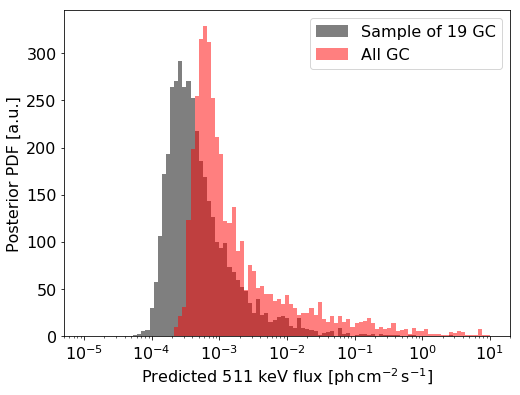

In [593]:
plt.hist(chain_sysxy_fam_dm['GC511_flux_total_sample'],np.logspace(-5,1,100),alpha=0.5,label='Sample of 19 GC');
plt.hist(chain_sysxy_fam_dm['GC511_flux_total_GC'],np.logspace(-5,1,100),alpha=0.5,label='All GC');
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')
plt.legend()

<h3>Looks like something went wrong the total flux of the GCs?: The dark matter model can predict some very high values for the flux of GC only (this is mainly due to the error bars of individual sources)</h3>

Text(0, 0.5, 'Posterior PDF [a.u.]')

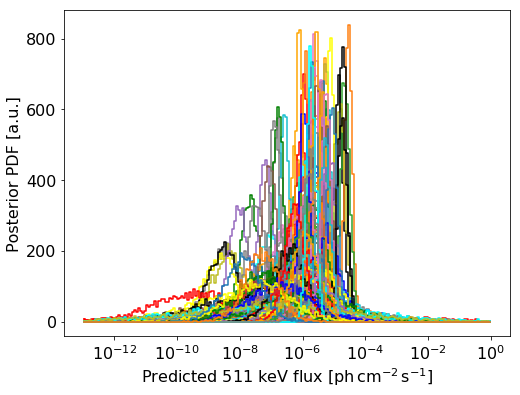

In [595]:
nbins = 200
five11_flux_edges_fam_dm_all = np.logspace(-13,0,nbins+1)
five511_flux_bins_fam_dm_all = (five11_flux_edges_fam_dm_all[0:-1]+five11_flux_edges_fam_dm_all[1:])/2
gc511_pdfs_fam_dm_all = np.zeros((len(M_DM.values),nbins))
for i in range(len(M_DM.values)):
    gc511_pdfs_fam_dm_all[i,:] = (np.histogram(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),bins=np.logspace(-13,0,nbins+1)))[0]
for i in range(len(M_DM.values)):
    plt.step(five511_flux_bins_fam_dm_all,gc511_pdfs_fam_dm_all[i,:],where='mid')
plt.xscale('log')
plt.xlabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.ylabel('Posterior PDF [a.u.]')

(1e-10, 0.001)

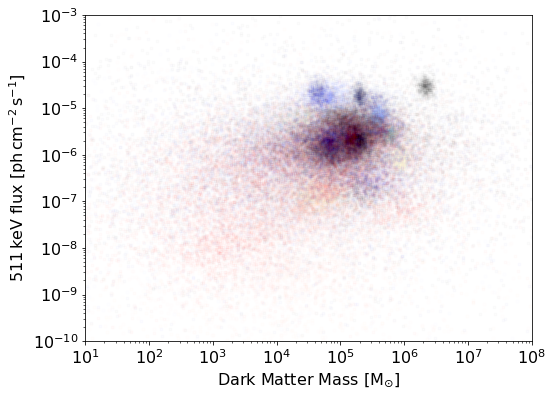

In [597]:
for i in range(len(Mstar.values)):
    plt.loglog(chain_sysxy_fam_dm['GC_ppc_x'][::10,i],chain_sysxy_fam_dm['five11_flux_GC'][::10,i],'.',alpha=0.01,color=plt.cm.flag(colors_m(Mstar[i])))
plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')

plt.xlim(1e1,1e8)
plt.ylim(1e-10,1e-3)

In [598]:
gc511_sysxy_fam_dm_all = []
gc511_sysxy_fam_dm_all_errlo = []
gc511_sysxy_fam_dm_all_errhi = []
for i in range(len(Mstar)):
    gc511_sysxy_fam_dm_all.append(np.percentile(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),50))
    gc511_sysxy_fam_dm_all_errhi.append(np.percentile(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),50+68.3/2) - 
                              np.percentile(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),50))
    gc511_sysxy_fam_dm_all_errlo.append(np.percentile(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),50) - 
                              np.percentile(chain_sysxy_fam_dm['five11_flux_GC'][:,i].ravel(),50-68.3/2))
gc511_sysxy_fam_dm_all = np.array(gc511_sysxy_fam_dm_all).reshape(len(gc511_sysxy_fam_dm_all))
gc511_sysxy_fam_dm_all_errlo = np.array(gc511_sysxy_fam_dm_all_errlo).reshape(len(gc511_sysxy_fam_dm_all))
gc511_sysxy_fam_dm_all_errhi = np.array(gc511_sysxy_fam_dm_all_errhi).reshape(len(gc511_sysxy_fam_dm_all))

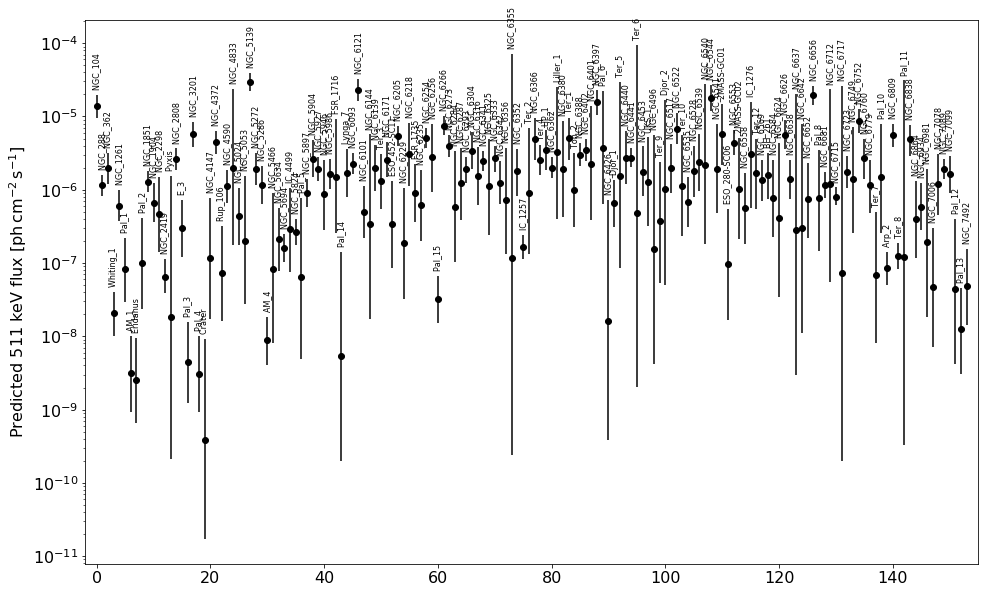

In [599]:
plt.figure(figsize=(16,10))
plt.errorbar(np.arange(len(M_DM.values)),gc511_sysxy_fam_dm_all,
             yerr=(gc511_sysxy_fam_dm_all_errlo,gc511_sysxy_fam_dm_all_errhi),fmt='o')
for i in range(len(M_DM.values)):
    plt.text(NsrcGC[i],gc511_sysxy_fam_dm_all[i]+gc511_sysxy_fam_dm_all_errhi[i],'  '+names2[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
#plt.ylim(-8,1)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.xlim(-2,155)
plt.yscale('log')

<h3>Well, actually, the uncertainties for some of the sources are so large, that the propagated uncertainty for the total flux of all 154 GCs can be dominated by them.</h3>

<h3>Of course, the predicted pattern are the somewhat the same because the masses do not change drastically...<br>
    There is not much information gained by doing this analysis. Adding the dwarf satellites is will probably change the thing (later...)</h3>

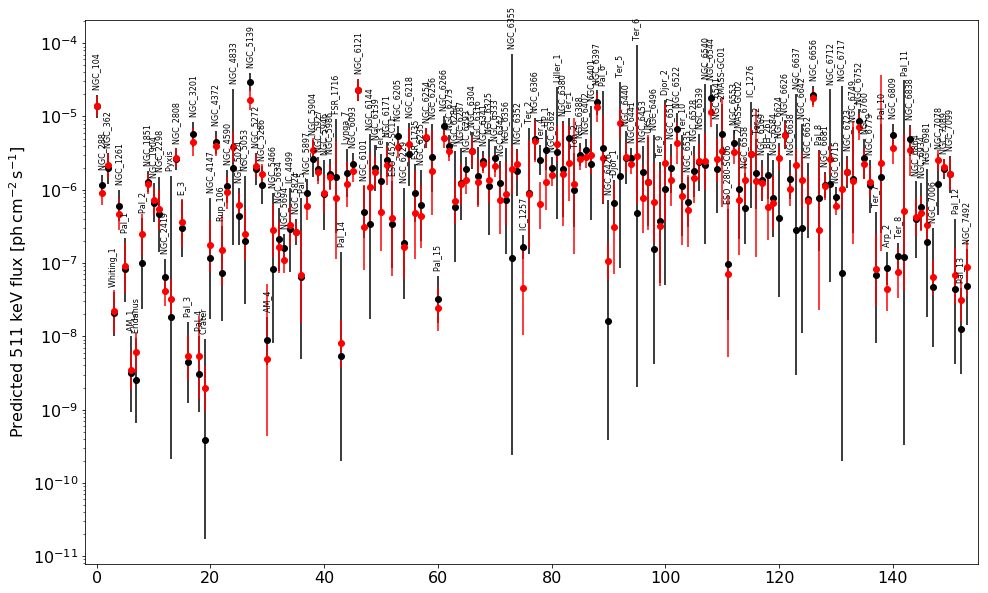

In [601]:
plt.figure(figsize=(16,10))
plt.errorbar(np.arange(len(M_DM.values)),gc511_sysxy_fam_dm_all,
             yerr=(gc511_sysxy_fam_dm_all_errlo,gc511_sysxy_fam_dm_all_errhi),fmt='ko')
plt.errorbar(np.arange(len(M_DM.values)),gc511_sysxy_fam_all,
             yerr=(gc511_sysxy_fam_all_errlo,gc511_sysxy_fam_all_errhi),fmt='ro')
for i in range(len(M_DM.values)):
    plt.text(NsrcGC[i],gc511_sysxy_fam_dm_all[i]+gc511_sysxy_fam_dm_all_errhi[i],'  '+names2[i],
             rotation=90,verticalalignment='bottom',horizontalalignment='center',fontsize=8)
#plt.ylim(-8,1)
plt.ylabel('Predicted 511 keV flux [$\mathrm{ph\,cm^{-2}\,s^{-1}}$]')
plt.xlim(-2,155)
plt.yscale('log')

In [603]:
masses511_dm = mdm_all[19:21]
masses511_dm_err = mdm_all_err[19:21]
L511_dm = np.array([5.3e35,6.3e36])#,1.7e37])#np.array([0.8e-4,0.96e-3,1.7e-3])
L511_dm_err = np.array([7.9e34,4.6e35])#,2.9e36]) #np.array([0.12e-4,0.07e-3,0.3e-3])

In [604]:
# dictionary for data set and prior
data511_dm = dict(N = 2,
            x_obs = masses511_dm,
            y_obs = L511_dm,
            sigma_x = masses511_dm_err,
            sigma_y = L511_dm_err,
            N_model = N_model,
            x_model = x_model,
            mu_lgNorm = 31.5,
            sigma_lgNorm = 1.0,
            mu_alpha = 1.0,
            sigma_alpha = 0.5)

In [605]:
# fit the model
fit_pl_511_dm = model_pl.sampling(data=data511_dm,verbose=True,chains=1,iter=10000,algorithm='HMC')

In [606]:
print(fit_pl_511_dm.stansummary(['lgNorm','alpha']))

Inference for Stan model: anon_model_4b3db346f8e8f36212ed3cf0b239486f.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lgNorm  30.98    0.07   0.42  30.03  30.73   31.0  31.26  31.71     33   1.06
alpha     0.6  8.2e-3   0.05   0.52   0.57    0.6   0.63   0.71     32   1.07

Samples were drawn using HMC at Thu Nov 14 15:50:21 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [607]:
chain_511_dm = fit_pl_511_dm.extract()

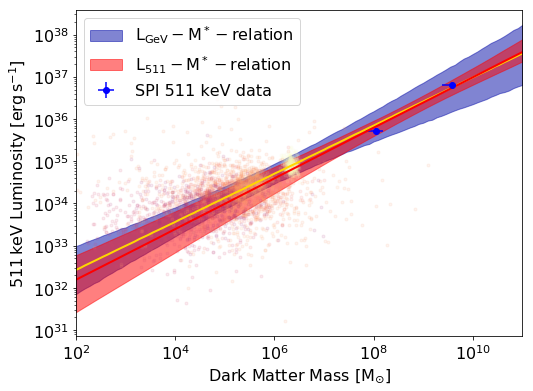

In [610]:
for i in range(len(random_idx_save)):
    plt.loglog(chain_sysxy_fam_dm['GC_ppc_x'][::10,random_idx_save[i]],
               chain_sysxy_fam_dm['five11_flux_GC'][::10,random_idx_save[i]]*1.19e44*dist2[random_idx_save[i]]**2/1.2e6,'.',alpha=0.1,
               color=plt.cm.magma(colors2(np.log10(Mstar.values[random_idx_save[i]]))))


plt.errorbar(masses511_dm,L511_dm,
             xerr=masses511_dm_err,yerr=L511_dm_err,fmt='bo',label='SPI 511 keV data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain_sysxy_fam_dm['powerlaw511'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_sysxy_fam_dm['powerlaw511'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=0.5,label=r'$\mathrm{L_{GeV}-M^*}-$relation')

plt.fill_between(x_model,
                np.percentile(chain_511_dm['powerlaw'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain_511_dm['powerlaw'], 50 + 0.5*level, axis=0 ),
                color='red',alpha=0.5,label=r'$\mathrm{L_{511}-M^*}-$relation')



fit_model_dm = np.median(chain_sysxy_fam_dm['powerlaw511'],axis=0)
fit_model511_dm = np.median(chain_511_dm['powerlaw'],axis=0)
plt.plot(x_model,fit_model_dm,linewidth=2,color='gold')
plt.plot(x_model,fit_model511_dm,linewidth=2,color='red')
    
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Dark Matter Mass [$\mathrm{M_{\odot}}$]')
plt.ylabel(r'$511\,\mathrm{keV}$ Luminosity [$\mathrm{erg\,s^{-1}}$]')

plt.xlim(1e2,1e11)
#plt.ylim(1e-13,1e-1)

plt.legend()


<h3>The correlation and expecation look better, but the uncertainties for individual sources are all over the place ...</h3>

<h2>TBD:<br>
    1) Creating the SPI data set for the entire mission in the 511 keV bin only to test the hypotheses<br>
    2) Create several (100s?) of templates for the stellar mass correlation with GeV for fits with SPI<br>
    3) Use different "disk" templates as it is now known how much influence this thing has<br>
    4) Talk to Fiona about propagation and where the things could end up (bulge disk)<br>
    5) The absolute flux (normalisation) is measured with SPI and also can serve as an exclusion criterion for different scenarios<br>
    6) Do all the fits ...<br>
    </h2>

In [1900]:
(0.96e-3/u.cm**2/u.s * 4*np.pi * (8.2*u.kpc)**2 * 511*u.keV).to(u.erg/u.s)

<Quantity 6.32326208e+36 erg / s>

In [1901]:
6.3e36 / 2e37

0.315

In [1930]:
(4*np.pi*u.kpc**2).to(u.cm**2)

<Quantity 1.19649518e+44 cm2>

In [1931]:
(u.erg).to(511*u.keV)

1221430.357315706